In [1]:
import warnings 
warnings.simplefilter('ignore')

import scanpy as sc
import scparadise
import muon as mu
import pandas as pd
import numpy as np
import anndata
import os

In [3]:
os.chdir('/mnt/c/Users/vadim/scRNA/scParadise/scripts_article')

In [5]:
!wget https://datasets.cellxgene.cziscience.com/4ddf2520-dca9-4db5-8233-1f81a1aab980.h5ad

--2025-06-24 12:34:25--  https://datasets.cellxgene.cziscience.com/4ddf2520-dca9-4db5-8233-1f81a1aab980.h5ad
52.85.49.17, 52.85.49.28, 52.85.49.24, ...m (datasets.cellxgene.cziscience.com)... 
Connecting to datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)|52.85.49.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5869793736 (5.5G) [binary/octet-stream]
Saving to: ‘4ddf2520-dca9-4db5-8233-1f81a1aab980.h5ad’

        4ddf2520-dc   3%[                    ] 173.49M  3.49MB/s    eta 27m 39s^C


In [7]:
# Load data
adata = sc.read_h5ad('4ddf2520-dca9-4db5-8233-1f81a1aab980.h5ad') 
adata

AnnData object with n_obs × n_vars = 245878 × 27484
    obs: 'Annotated_Clusters', 'LibraryID', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Seurat_Clusters', 'BMI', 'HbA1c', 'Islet', 'UNOS', 'Center', 'Medication', 'Viability', 'Purity', 'Cause_of_death', 'Multiplex', 'BMI_Category', 'Clusters_DiseaseState', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'celltype', 'celltype_l1'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'batch_condition', 'citation', 

In [ ]:
# Get raw counts from adata.raw
adata = adata.raw.to_adata()

In [ ]:
# Convert var_names from ENSG codes to gene names
adata.var.set_index('feature_name', inplace=True)
adata.var_names_make_unique()

In [ ]:
# Rename cell types
cluster_list = adata.obs['cell_type'].unique()
# Make cluster anottation dictionary
annotation = {
    'Beta': ['type B pancreatic cell'],
    'Alpha': ['pancreatic A cell'],
    'Ductal': ['pancreatic ductal cell'],
    'Acinar': ['pancreatic acinar cell'],
    'Stellate':['pancreatic stellate cell'],
    'Delta':['pancreatic D cell'],
    'Endothelial': ['endothelial cell'],
    'PP': ['pancreatic PP cell'],
    'Leukocyte': ['leukocyte'],
    'Mast': ['mast cell'],
    'Schwann': ['Schwann cell'],
    'Epsilon': ['pancreatic epsilon cell']
}

# Change dictionary format
annotation_rev = {}
for i in cluster_list:
    for k in annotation:
        if i in annotation[k]:
            annotation_rev[i] = k

adata.obs["celltype_l1"] = [annotation_rev[i] for i in adata.obs['cell_type']]

In [73]:
adata.write_h5ad('Pancreas/adata.h5ad')

In [77]:
# Save counts data to use Seurat and Azimuth
import scipy
adata.layers['counts'] = adata.X.copy()
# Save raw filtered counts and meta data for Azimuth
destination = 'Pancreas/dataset'
adata.obs.to_csv(os.path.join(destination, "metadata.csv"))
# RNA
destination = 'Pancreas/dataset/RNA'
pd.DataFrame(index = adata.var.index).to_csv(os.path.join(destination, "features.tsv" ), sep = "\t", header=False)
pd.DataFrame(index = adata.obs.index).to_csv(os.path.join(destination, "barcodes.tsv"), sep = "\t", header=False)
scipy.io.mmwrite(os.path.join(destination, "matrix.mtx"), adata.layers['counts'].T)

In [8]:
# Create training and testing datasets
adata_train_1 = adata[adata.obs['donor_id'].isin(['SAMN16365027', 'SAMN17528599'])].copy()
adata_train_2 = adata[adata.obs['donor_id'].isin(['SAMN08769026', 'SAMN11523048', 'SAMN11633049'])].copy()	
adata_test_1 = adata[adata.obs['donor_id'].isin(['HP-20152-01'])].copy()
adata_test_2 = adata[adata.obs['donor_id'].isin(['HP17225-01T2D'])].copy()
adata_test_3 = adata[adata.obs['donor_id'].isin(['HP19047-01'])].copy()
adata_test_4 = adata[adata.obs['donor_id'].isin(['SAMN11867362'])].copy()
adata_test_5 = adata[adata.obs['donor_id'].isin(['SAMN12022246'])].copy()
adata_test_6 = adata[adata.obs['donor_id'].isin(['SAMN13108021', 'SAMN11642375'])].copy()
adata_test_7 = adata[adata.obs['donor_id'].isin(['SAMN11476721', 'SAMN10873960'])].copy()
adata_test_8 = adata[adata.obs['donor_id'].isin(['SAMN10439569', 'SAMN10737781'])].copy()
adata_test_9 = adata[adata.obs['donor_id'].isin(['SAMN13319813', 'SAMN11522709'])].copy()
adata_test_10 = adata[adata.obs['donor_id'].isin(['HP18304', 'SAMN11157311'])].copy()

# Normalize data, find highly variable features
for i in [adata_train_1, adata_train_2, adata_test_1, adata_test_2, adata_test_3, adata_test_4, adata_test_5, adata_test_6, adata_test_7, adata_test_8, adata_test_9, adata_test_10]:
    i.layers['counts'] = i.X.copy()
    sc.pp.normalize_total(i, target_sum=None)
    sc.pp.log1p(i)
    i.raw = i

In [85]:
# Find genes for model training (marker genes of cell types)
lst_genes = []
annotations = ['celltype_l1'] # annotation levels
for annotation in annotations:
    sc.tl.rank_genes_groups(adata_train_1, 
                            groupby = annotation,
                            method = 't-test_overestim_var', pts = True)
    # Filter marker genes of cell types
    sc.tl.filter_rank_genes_groups(adata_train_1, 
                                   min_fold_change = 1.0, 
                                   min_in_group_fraction = 0.4,
                                   key_added = 'filtered_rank_genes_groups')
    # Create list of genes for model training

    for i in adata_train_1.obs[annotation].unique():
        df = sc.get.rank_genes_groups_df(adata_train_1, group = i, key = 'filtered_rank_genes_groups', pval_cutoff = 0.05)
        df['pts_comparizon'] = df['pct_nz_group']/df['pct_nz_reference']
        lst_genes.extend(df.sort_values(by = 'logfoldchanges', ascending = False).head(50)['names'].tolist())
        lst_genes.extend(df.sort_values(by = 'pts_comparizon', ascending = False).head(50)['names'].tolist())
# Remove duplicates 
lst_genes = np.unique(lst_genes).tolist()
len(lst_genes)

530

In [33]:
df_genes = pd.DataFrame(lst_genes, columns = ['genes'])
df_genes.to_csv('Pancreas/genes_for_AI.csv')

In [9]:
# Subset anndata object based on a selected marker genes
genes = pd.read_csv('Pancreas/genes_for_AI.csv')
adata_train_1 = adata_train_1[:, genes.genes].copy()

In [10]:
# Balance dataset based on annotation level
adata_train_1_balanced = scparadise.scnoah.balance(adata_train_1, 
                                                   sample='donor_id',
                                                   celltype_l1='celltype')

Successfully undersampled cell types: Beta, Alpha

Successfully oversampled cell types: Ductal, Delta, Stellate, PP, Acinar, Endothelial, Leukocyte, Schwann, Epsilon, Mast


In [11]:
# Train scadam model using adata_balanced dataset
scparadise.scadam.train(adata_train_1_balanced,
                        path = '',
                        model_name = 'model_Pancreas_scAdam_default',
                        celltype_l1 = 'celltype_l1',
                        eval_metric = ['accuracy'])

Successfully saved genes names for training model

Successfully saved dictionary of dataset annotations

Train dataset contains: 10076 cells, it is 90.0 % of input dataset
Test dataset contains: 1120 cells, it is 10.0 % of input dataset

Accelerator: cuda
Training unsupervised model
epoch 0  | loss: 8.40692 | val_0_unsup_loss_numpy: 1.2961699962615967|  0:00:00s
epoch 1  | loss: 2.19321 | val_0_unsup_loss_numpy: 1.191640019416809|  0:00:01s
epoch 2  | loss: 1.26217 | val_0_unsup_loss_numpy: 1.1850199699401855|  0:00:02s
epoch 3  | loss: 1.07863 | val_0_unsup_loss_numpy: 1.0360300540924072|  0:00:02s
epoch 4  | loss: 1.01741 | val_0_unsup_loss_numpy: 1.006909966468811|  0:00:03s
epoch 5  | loss: 1.00468 | val_0_unsup_loss_numpy: 0.9938499927520752|  0:00:03s
epoch 6  | loss: 0.99504 | val_0_unsup_loss_numpy: 0.977400004863739|  0:00:04s
epoch 7  | loss: 0.98202 | val_0_unsup_loss_numpy: 0.9564999938011169|  0:00:04s
epoch 8  | loss: 0.96665 | val_0_unsup_loss_numpy: 0.9344900250434875| 

In [12]:
# Create lists with test samples
lst_test_folders = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
lst_test_adatas = [adata_test_1, adata_test_2, adata_test_3, adata_test_4, adata_test_5, adata_test_6, adata_test_7, adata_test_8, adata_test_9, adata_test_10]

In [88]:
for adata_test, folder in zip(lst_test_adatas, lst_test_folders):
    os.makedirs(os.path.join('Pancreas/scadam_default/reports', folder))
    # Predict annotation levels using pretrained scadam model
    adata_test = scparadise.scadam.predict(adata_test, 
                                           path_model = 'model_Pancreas_scAdam_default')
    # Create and save classification report of annotation levels
    scparadise.scnoah.report_classif_full(adata_test, 
                                          celltype = 'celltype', 
                                          pred_celltype = 'pred_celltype_l1', 
                                          report_name = 'report_test_model_scAdam_default_celltype_l1.csv',
                                          save_path = os.path.join('Pancreas/scadam_default/reports', folder).replace("\\","/"),
                                          save_report = True)

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training 

In [13]:
adata_test_10 = scparadise.scadam.predict(adata_test_10, 
                                         path_model = 'model_Pancreas_scAdam_default')
# Order cell type colors
# Celltype_l1
celltype = np.unique(adata_test_10.obs['celltype_l1']).tolist()
adata_test_10.obs['celltype_l1'] = pd.Categorical(
    values=adata_test_10.obs['celltype_l1'], categories=celltype, ordered=True
)
scparadise.scnoah.pred_status(adata_test_10, celltype='celltype_l1', pred_celltype='pred_celltype_l1', key_added='pred_status_l1')

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities


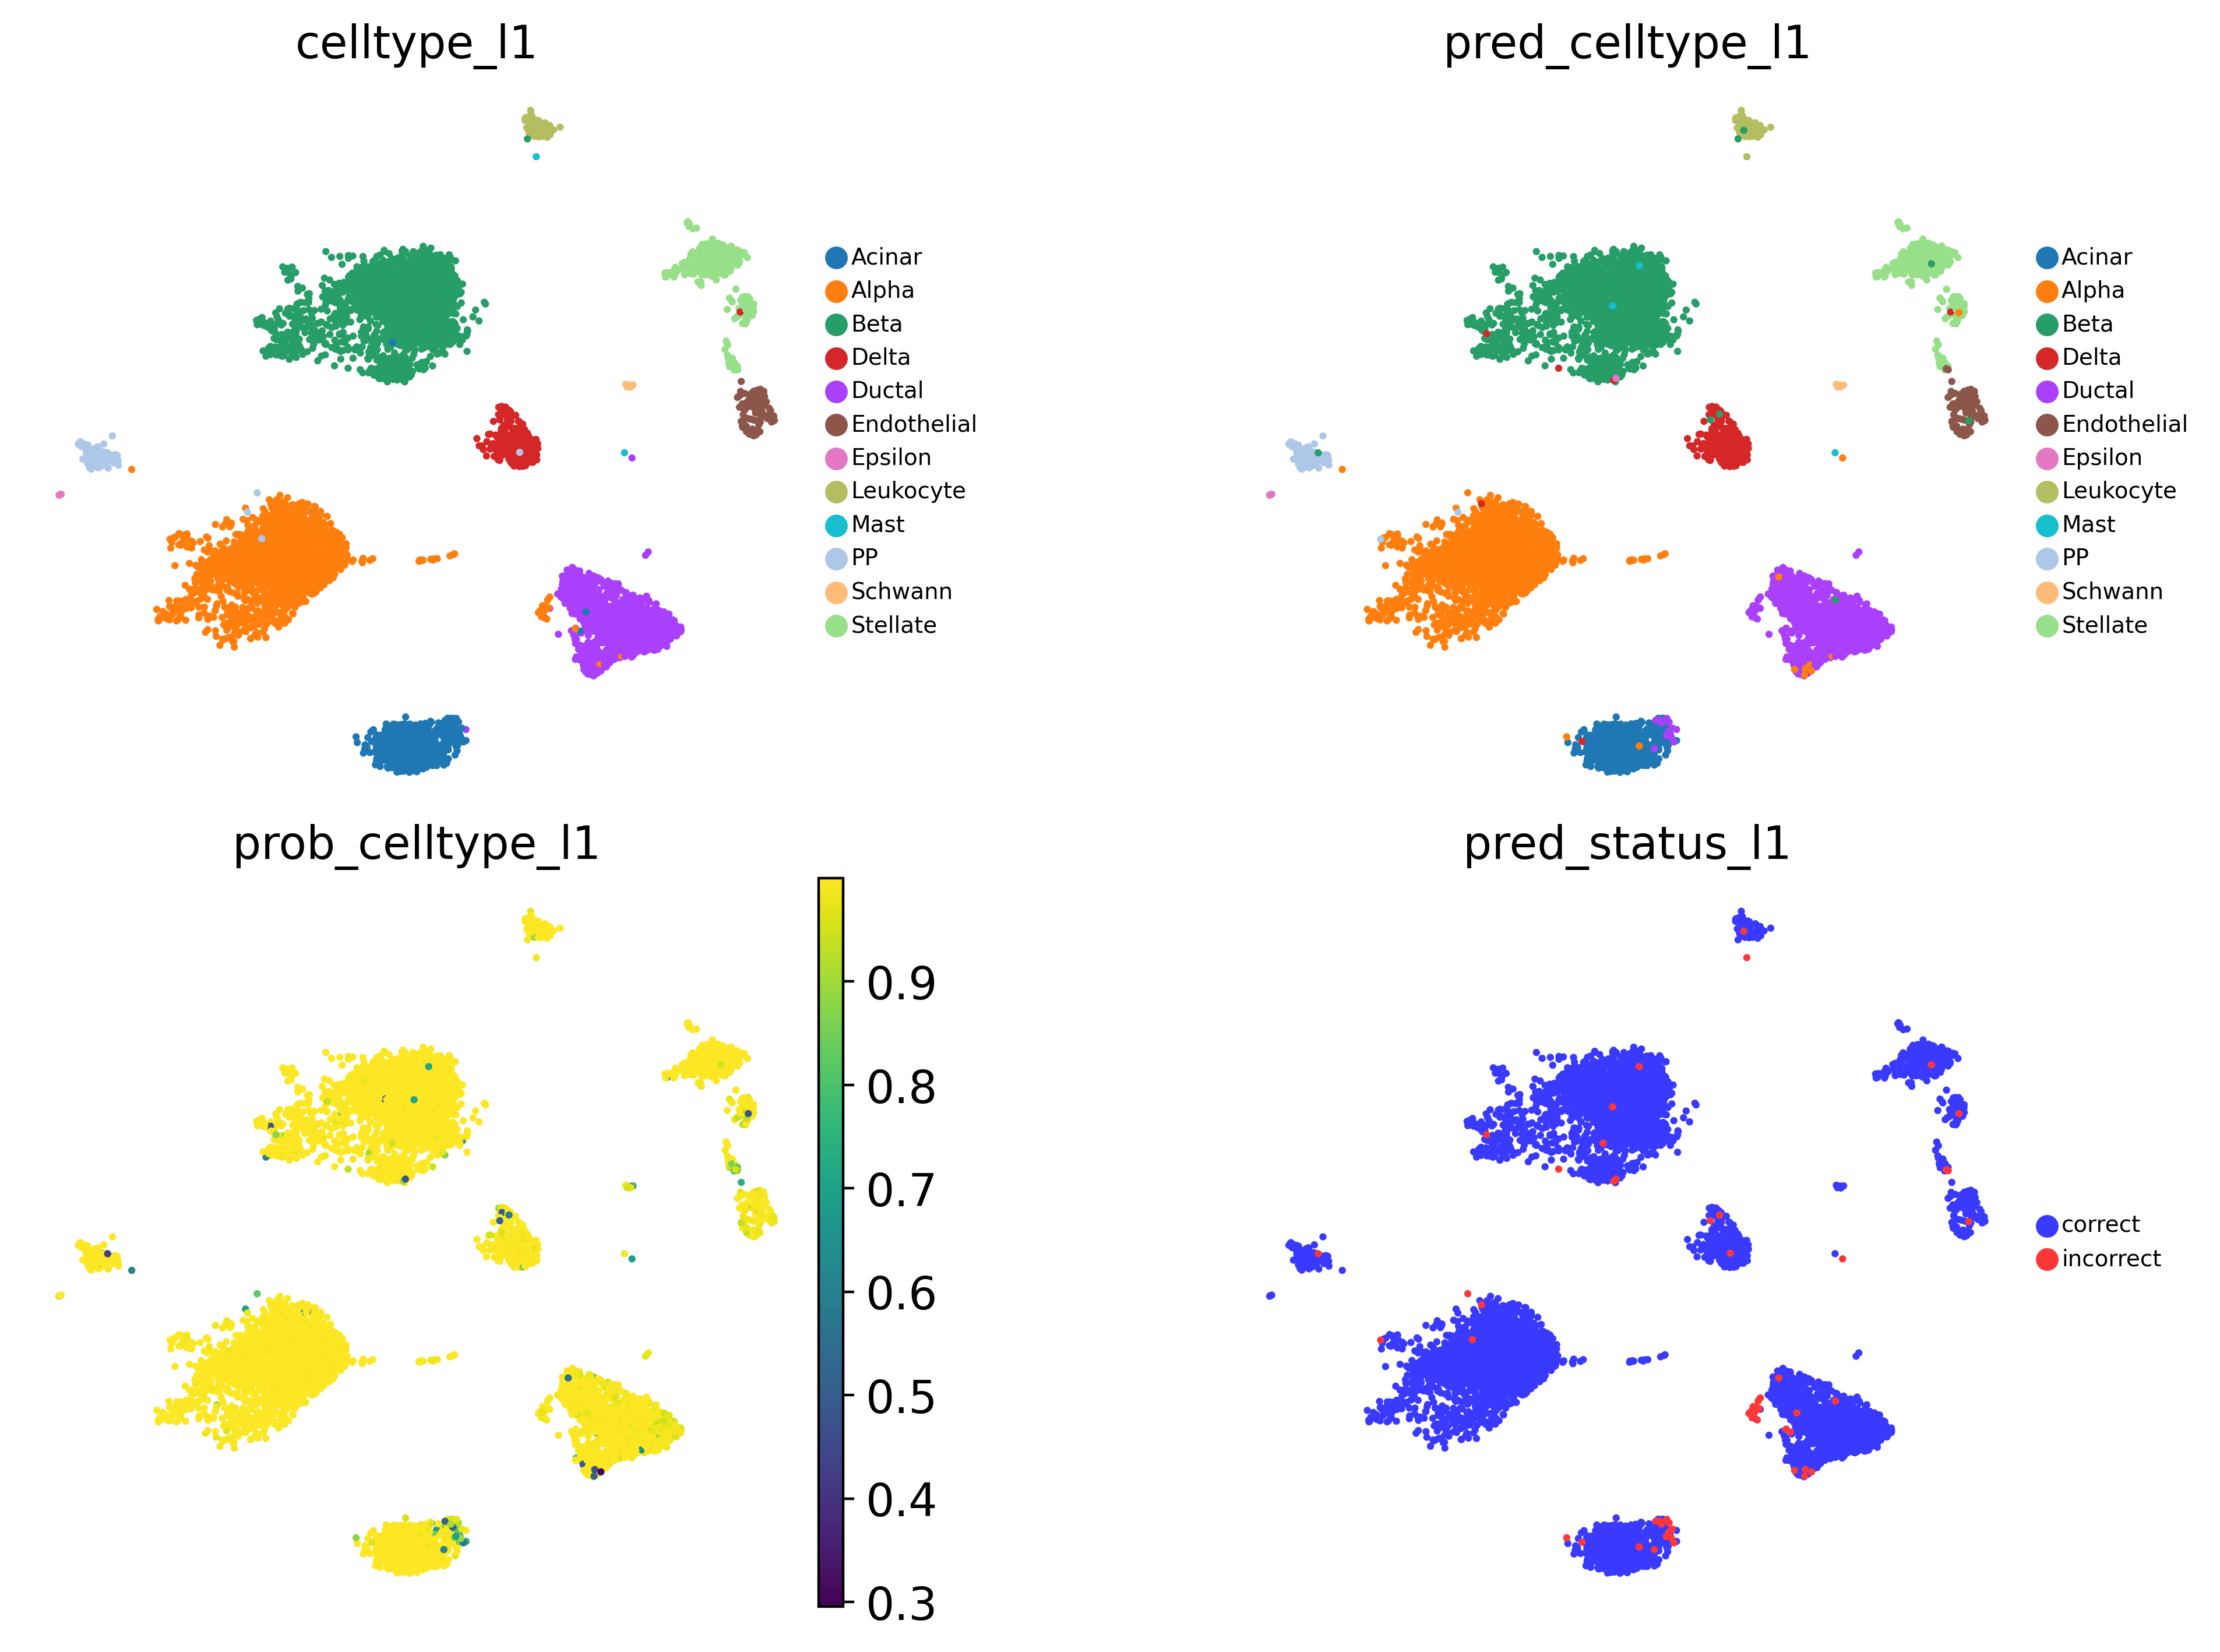

In [15]:
# Visualise predicted cell types levels, prediction probabilities and prediction status
sc.set_figure_params(dpi = 200, dpi_save=600)
adata_test_10 = adata_test_10[adata_test_10.obs['pred_status_l1'].sort_values().index,:]
sc.pl.embedding(adata_test_10, 
                color=[
                    'celltype_l1',
                    'pred_celltype_l1',
                    'prob_celltype_l1',
                    'pred_status_l1'
                ],
                sort_order = False,
                basis = 'X_umap',
                frameon = False,
                add_outline = False,
                legend_loc = 'right margin',
                legend_fontsize = 7,
                legend_fontoutline = 1,
                ncols=2,
                s = 20,
                wspace = 0.4, 
                hspace = 0.1,
                save = '_Pancreas_celltype_l1_scAdam_default.png')

# Warm start training

In [16]:
adata_train_2_balanced = scparadise.scnoah.balance(adata_train_2, 
                                                   sample='donor_id',
                                                   celltype_l1='celltype')

Successfully undersampled cell types: Beta, Alpha, Ductal

Successfully oversampled cell types: Delta, Acinar, Stellate, Endothelial, PP, Leukocyte, Mast, Epsilon, Schwann


In [17]:
adata_train_2_balanced.raw = adata_train_2_balanced

In [18]:
# Warm start requires second training dataset and path to pretrained model 
scparadise.scadam.warm_start(adata_train_2_balanced,
                             path='', # path to save model
                             model_name='model_Pancreas_scAdam_default', # folder name with pretrained model
                             celltype_l1='celltype_l1',
                             eval_metric=['accuracy'])

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Train dataset contains: 17787 cells, it is 90.0 % of input dataset
Test dataset contains: 1977 cells, it is 10.0 % of input dataset

Successfully loaded parameters

Accelerator: cuda
Start training
epoch 0  | loss: 0.31689 | train_accuracy: 0.98881 | valid_accuracy: 0.98988 |  0:00:02s
epoch 1  | loss: 0.22852 | train_accuracy: 0.99258 | valid_accuracy: 0.99292 |  0:00:03s
epoch 2  | loss: 0.2024  | train_accuracy: 0.99331 | valid_accuracy: 0.98786 |  0:00:04s
epoch 3  | loss: 0.18847 | train_accuracy: 0.99472 | valid_accuracy: 0.99241 |  0:00:06s
epoch 4  | loss: 0.18348 | train_accuracy: 0.99584 | valid_accuracy: 0.99342 |  0:00:07s
epoch 5  | loss: 0.16784 | train_accuracy: 0.99606 | valid_accuracy: 0.9914  |  0:00:09s
epoch 6  | loss: 0.16199 | train_accuracy: 0.99736 | valid_accuracy: 0.99393 |  0:00:10s
epoch 7  | loss: 0.16162 | train_accuracy: 0.99719 | valid_accura

In [117]:
for adata_test, folder in zip(lst_test_adatas, lst_test_folders):
    os.makedirs(os.path.join('Pancreas/scadam_warm_start/reports', folder))
    # Predict annotation levels using pretrained scadam model
    adata_test = scparadise.scadam.predict(adata_test, 
                                           path_model = 'model_Pancreas_scAdam_default')
    # Create and save classification report of annotation levels
    scparadise.scnoah.report_classif_full(adata_test, 
                                          celltype = 'celltype', 
                                          pred_celltype = 'pred_celltype_l1', 
                                          report_name = 'report_test_model_scAdam_default_celltype_l1.csv',
                                          save_path = os.path.join('Pancreas/scadam_warm_start/reports', folder).replace("\\","/"),
                                          save_report = True)

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training 

In [19]:
adata_test_10 = scparadise.scadam.predict(adata_test_10, 
                                         path_model = 'model_Pancreas_scAdam_default')
# Order cell type colors
# Celltype_l1
celltype = np.unique(adata_test_10.obs['celltype_l1']).tolist()
adata_test_10.obs['celltype_l1'] = pd.Categorical(
    values=adata_test_10.obs['celltype_l1'], categories=celltype, ordered=True
)
scparadise.scnoah.pred_status(adata_test_10, celltype='celltype_l1', pred_celltype='pred_celltype_l1', key_added='pred_status_l1')

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities


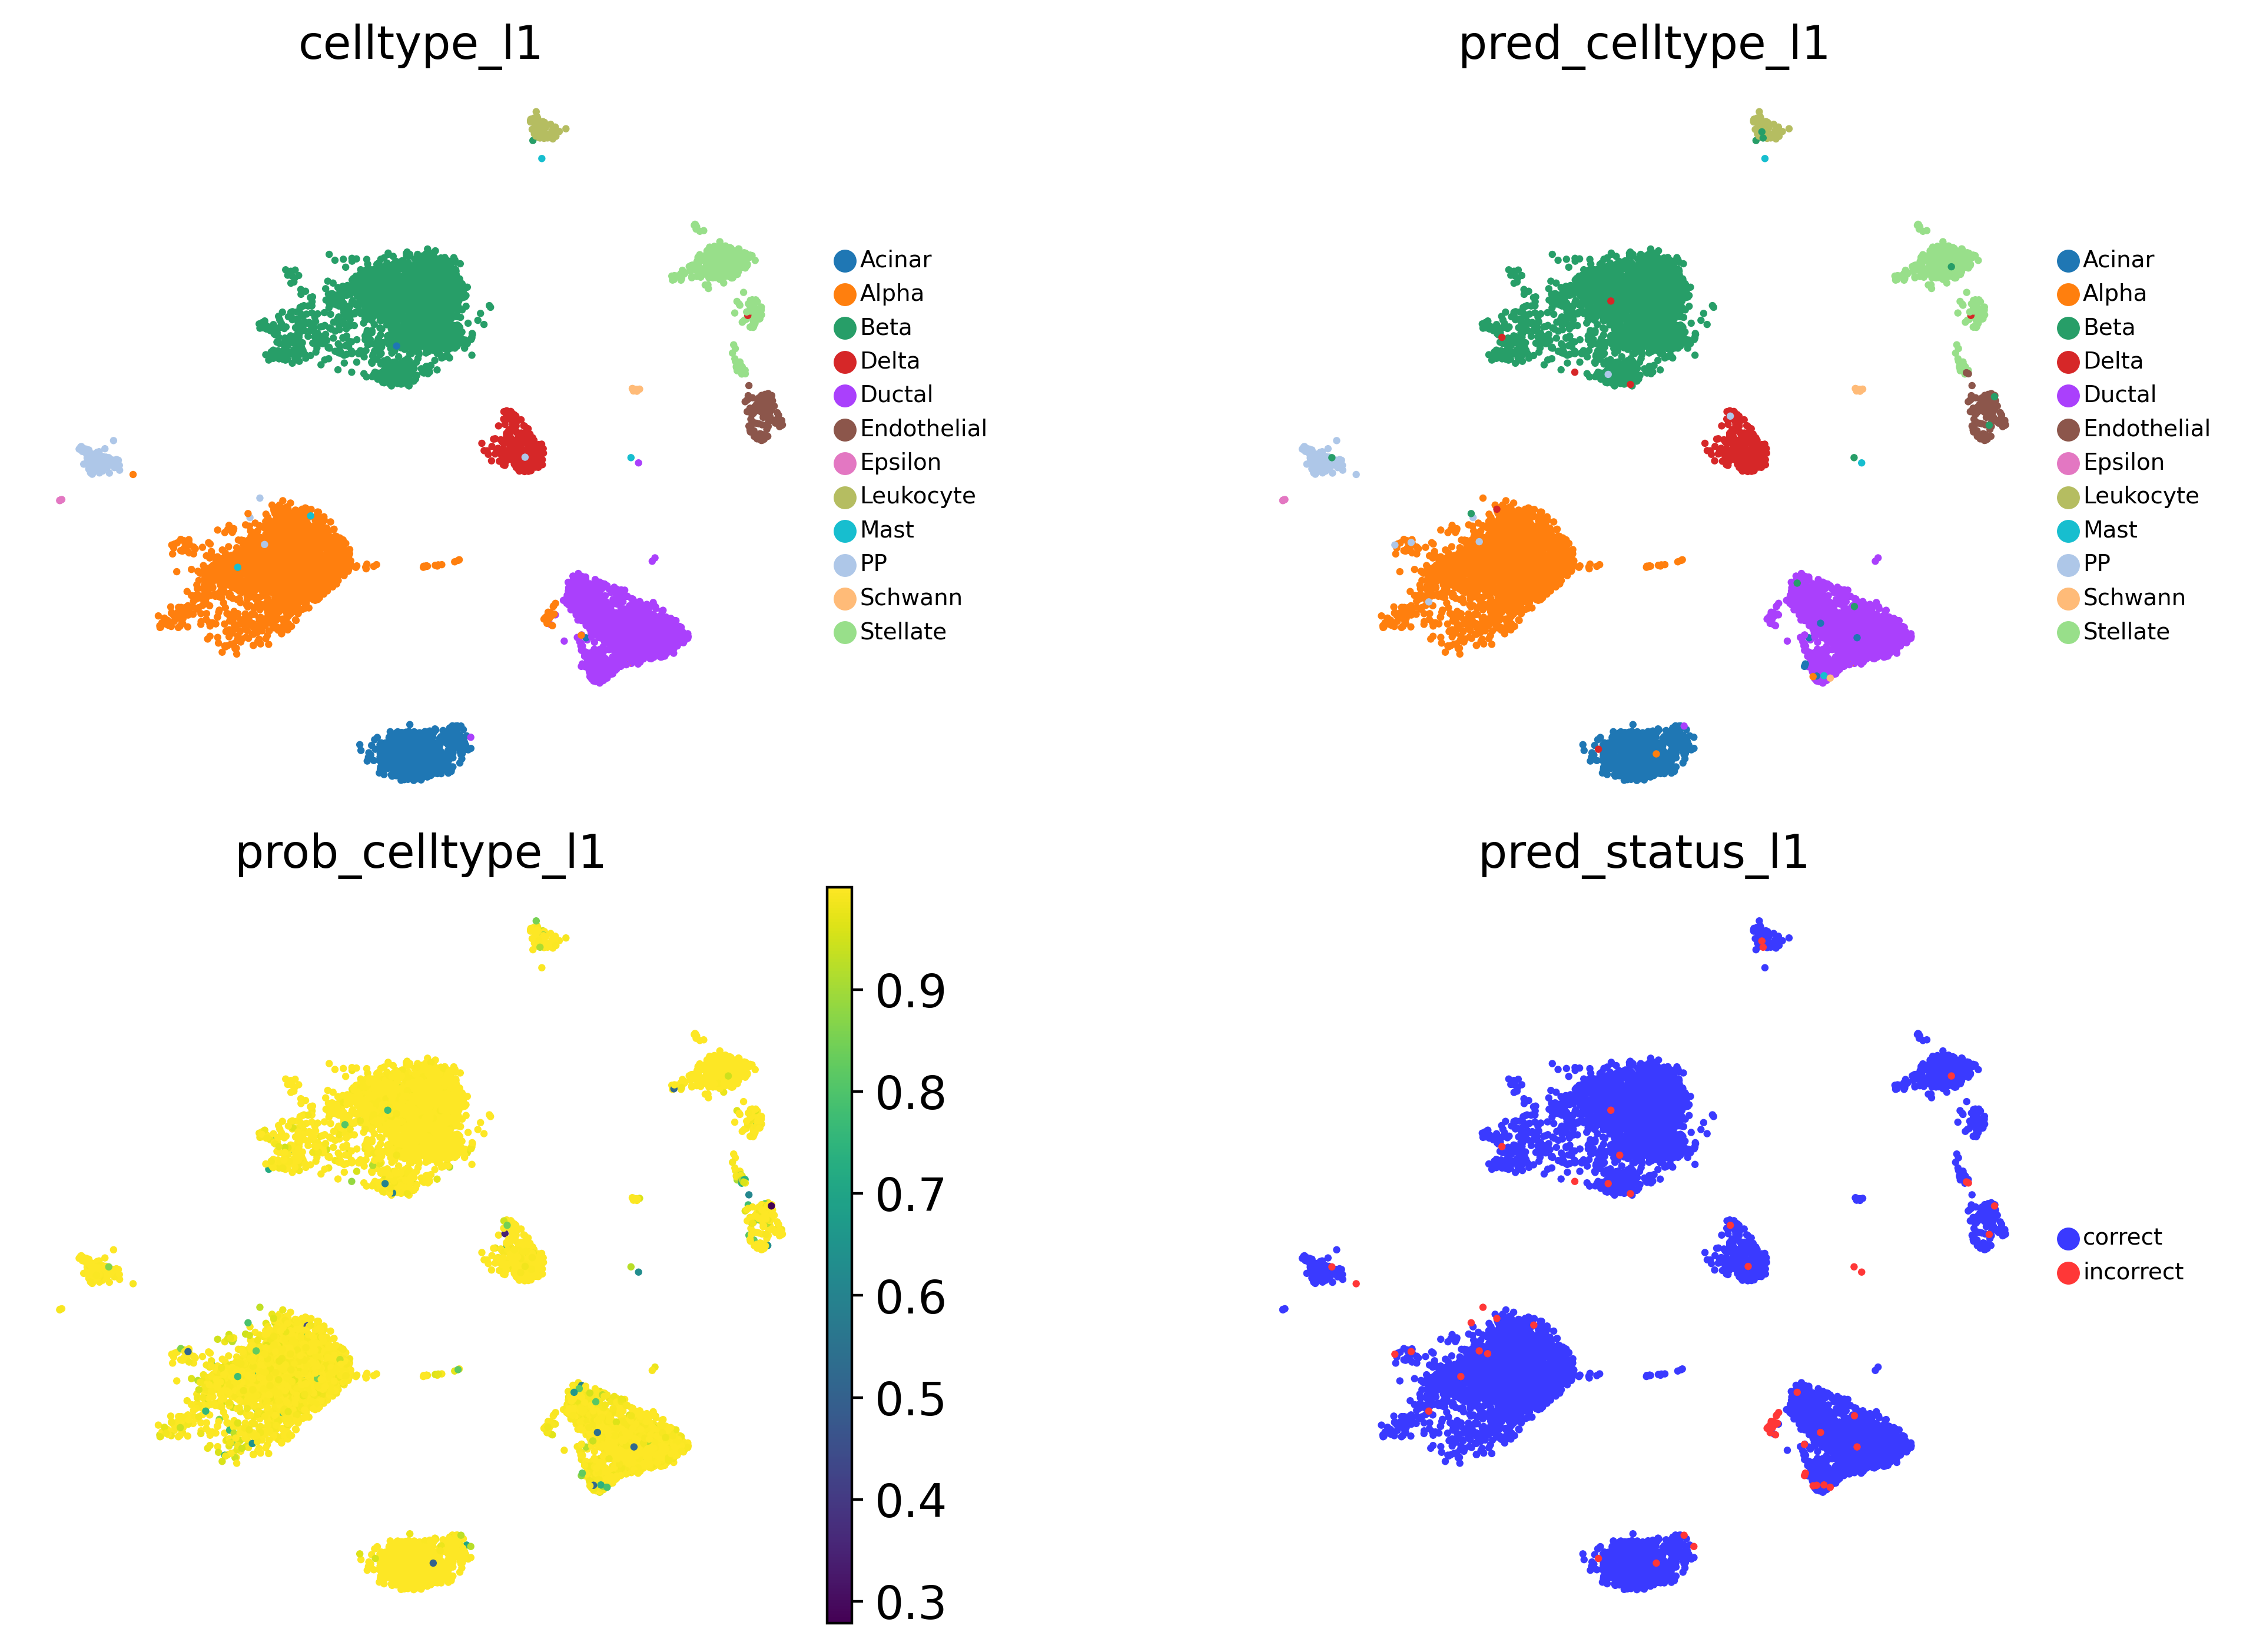

In [20]:
# Visualise predicted cell types levels, prediction probabilities and prediction status
sc.set_figure_params(dpi = 200, dpi_save=600)
adata_test_10 = adata_test_10[adata_test_10.obs['pred_status_l1'].sort_values().index,:]
sc.pl.embedding(adata_test_10, 
                color=[
                    'celltype_l1',
                    'pred_celltype_l1',
                    'prob_celltype_l1',
                    'pred_status_l1'
                ],
                sort_order = False,
                basis = 'X_umap',
                frameon = False,
                add_outline = False,
                legend_loc = 'right margin',
                legend_fontsize = 7,
                legend_fontoutline = 1,
                ncols=2,
                s = 20,
                wspace = 0.4, 
                hspace = 0.1,
                save = '_Pancreas_celltype_l1_scAdam_warm_start.png')

# Hyperparameter tuning

In [45]:
scparadise.scadam.hyperparameter_tuning(adata_train_1_balanced,
                                        path='',
                                        model_name='model_Pancreas_scadam_tuning', # Folder to save hyperparameter tuning results
                                        celltype_l1='celltype_l1',
                                        random_state=1,
                                        num_trials=200, # The number of attempts to find the optimal hyperparameters for the model (recommended - minimum 100)
                                        eval_metric=['accuracy'])

Successfully saved genes names for training model

Successfully saved dictionary of dataset annotations

Accelerator: cuda



[I 2025-05-18 15:17:40,900] A new study created in RDB with name: model_Pancreas_scadam_tuning


Fold 1:

Early stopping occurred at epoch 55 with best_epoch = 45 and best_valid_accuracy = 0.99464

Fold 2:

Early stopping occurred at epoch 55 with best_epoch = 45 and best_valid_accuracy = 0.99786

Fold 3:

Early stopping occurred at epoch 58 with best_epoch = 48 and best_valid_accuracy = 0.99786

Fold 4:

Early stopping occurred at epoch 54 with best_epoch = 44 and best_valid_accuracy = 0.99678


[I 2025-05-18 15:19:26,979] Trial 0 finished with value: 0.9967845659163987 and parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 3, 'n_shared': 2, 'cat_emb_dim': 1, 'n_independent': 1, 'gamma': 1.3, 'momentum': 0.02, 'lr': 0.01, 'mask_type': 'entmax', 'lambda_sparse': 0.001, 'patience': 10, 'max_epochs': 100, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 0 with value: 0.9967845659163987.



Fold 1:

Early stopping occurred at epoch 18 with best_epoch = 13 and best_valid_accuracy = 0.99786

Fold 2:

Early stopping occurred at epoch 17 with best_epoch = 12 and best_valid_accuracy = 0.99678

Fold 3:

Early stopping occurred at epoch 15 with best_epoch = 10 and best_valid_accuracy = 0.99571

Fold 4:

Early stopping occurred at epoch 22 with best_epoch = 17 and best_valid_accuracy = 0.99678



[I 2025-05-18 15:19:56,076] Trial 1 finished with value: 0.9967845659163987 and parameters: {'n_d': 56, 'n_a': 96, 'n_steps': 1, 'n_shared': 4, 'cat_emb_dim': 2, 'n_independent': 1, 'gamma': 1.1862602113776708, 'momentum': 0.14476868354678862, 'lr': 0.1984440603679119, 'mask_type': 'entmax', 'lambda_sparse': 0.007069470359901731, 'patience': 5, 'max_epochs': 90, 'virtual_batch_size': 256, 'batch_size': 768}. Best is trial 0 with value: 0.9967845659163987.


Fold 1:

Early stopping occurred at epoch 41 with best_epoch = 31 and best_valid_accuracy = 0.55341


[I 2025-05-18 15:20:41,852] Trial 2 pruned. 


Fold 1:

Early stopping occurred at epoch 7 with best_epoch = 2 and best_valid_accuracy = 0.12826

Fold 2:

Early stopping occurred at epoch 18 with best_epoch = 13 and best_valid_accuracy = 0.26152

Fold 3:

Early stopping occurred at epoch 5 with best_epoch = 0 and best_valid_accuracy = 0.18435

Fold 4:

Early stopping occurred at epoch 17 with best_epoch = 12 and best_valid_accuracy = 0.31654


[I 2025-05-18 15:21:45,532] Trial 3 finished with value: 0.2226688102893891 and parameters: {'n_d': 8, 'n_a': 100, 'n_steps': 10, 'n_shared': 8, 'cat_emb_dim': 3, 'n_independent': 8, 'gamma': 1.103226006577642, 'momentum': 0.18467847520860303, 'lr': 0.45430689199623847, 'mask_type': 'entmax', 'lambda_sparse': 0.00022435885546638436, 'patience': 5, 'max_epochs': 70, 'virtual_batch_size': 512, 'batch_size': 2048}. Best is trial 0 with value: 0.9967845659163987.



Fold 1:

Early stopping occurred at epoch 69 with best_epoch = 54 and best_valid_accuracy = 0.99571

Fold 2:

Early stopping occurred at epoch 57 with best_epoch = 42 and best_valid_accuracy = 0.99357

Fold 3:

Early stopping occurred at epoch 76 with best_epoch = 61 and best_valid_accuracy = 0.99821

Fold 4:

Early stopping occurred at epoch 66 with best_epoch = 51 and best_valid_accuracy = 0.99607


[I 2025-05-18 15:25:56,806] Trial 4 finished with value: 0.995891389782065 and parameters: {'n_d': 24, 'n_a': 80, 'n_steps': 7, 'n_shared': 2, 'cat_emb_dim': 5, 'n_independent': 7, 'gamma': 1.4141792695269026, 'momentum': 0.02948184898897399, 'lr': 0.26799461331716423, 'mask_type': 'entmax', 'lambda_sparse': 0.03543503880316684, 'patience': 15, 'max_epochs': 95, 'virtual_batch_size': 512, 'batch_size': 1024}. Best is trial 0 with value: 0.9967845659163987.



Fold 1:
Stop training because you reached max_epochs = 65 with best_epoch = 60 and best_valid_accuracy = 0.95606


[I 2025-05-18 15:27:29,423] Trial 5 pruned. 


Fold 1:
Stop training because you reached max_epochs = 70 with best_epoch = 59 and best_valid_accuracy = 0.99786

Fold 2:

Early stopping occurred at epoch 63 with best_epoch = 43 and best_valid_accuracy = 0.9975

Fold 3:
Stop training because you reached max_epochs = 70 with best_epoch = 68 and best_valid_accuracy = 0.99821

Fold 4:
Stop training because you reached max_epochs = 70 with best_epoch = 52 and best_valid_accuracy = 0.99786


[I 2025-05-18 15:31:22,574] Trial 6 finished with value: 0.997856377277599 and parameters: {'n_d': 36, 'n_a': 120, 'n_steps': 6, 'n_shared': 1, 'cat_emb_dim': 7, 'n_independent': 4, 'gamma': 1.5270581022576093, 'momentum': 0.3555174187312021, 'lr': 0.17869915302524964, 'mask_type': 'entmax', 'lambda_sparse': 0.00011033189053588348, 'patience': 20, 'max_epochs': 70, 'virtual_batch_size': 128, 'batch_size': 1024}. Best is trial 6 with value: 0.997856377277599.



Fold 1:
Stop training because you reached max_epochs = 85 with best_epoch = 81 and best_valid_accuracy = 0.93569


[I 2025-05-18 15:32:03,257] Trial 7 pruned. 


Fold 1:
Stop training because you reached max_epochs = 25 with best_epoch = 23 and best_valid_accuracy = 0.99143


[I 2025-05-18 15:32:29,897] Trial 8 pruned. 


Fold 1:
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_valid_accuracy = 0.58307

Fold 2:
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_valid_accuracy = 0.51483

Fold 3:
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_valid_accuracy = 0.6781


[I 2025-05-18 15:32:39,349] Trial 9 pruned. 


Fold 1:
Stop training because you reached max_epochs = 40 with best_epoch = 34 and best_valid_accuracy = 0.99393

Fold 2:
Stop training because you reached max_epochs = 40 with best_epoch = 26 and best_valid_accuracy = 0.99678

Fold 3:
Stop training because you reached max_epochs = 40 with best_epoch = 31 and best_valid_accuracy = 0.9975


[I 2025-05-18 15:35:07,416] Trial 10 pruned. 


Fold 1:
Stop training because you reached max_epochs = 70 with best_epoch = 61 and best_valid_accuracy = 0.99714

Fold 2:
Stop training because you reached max_epochs = 70 with best_epoch = 60 and best_valid_accuracy = 0.99786

Fold 3:

Early stopping occurred at epoch 48 with best_epoch = 28 and best_valid_accuracy = 0.99643


[I 2025-05-18 15:37:50,624] Trial 11 pruned. 


Fold 1:

Early stopping occurred at epoch 23 with best_epoch = 13 and best_valid_accuracy = 0.99607

Fold 2:

Early stopping occurred at epoch 31 with best_epoch = 21 and best_valid_accuracy = 0.99714

Fold 3:

Early stopping occurred at epoch 30 with best_epoch = 20 and best_valid_accuracy = 0.99786

Fold 4:

Early stopping occurred at epoch 33 with best_epoch = 23 and best_valid_accuracy = 0.99643


[I 2025-05-18 15:41:09,593] Trial 12 finished with value: 0.9968738835298321 and parameters: {'n_d': 88, 'n_a': 56, 'n_steps': 5, 'n_shared': 1, 'cat_emb_dim': 6, 'n_independent': 3, 'gamma': 1.279391480861853, 'momentum': 0.2635266813064886, 'lr': 0.1915559158088834, 'mask_type': 'entmax', 'lambda_sparse': 0.0008761655583933668, 'patience': 10, 'max_epochs': 45, 'virtual_batch_size': 128, 'batch_size': 256}. Best is trial 6 with value: 0.997856377277599.



Fold 1:

Early stopping occurred at epoch 33 with best_epoch = 23 and best_valid_accuracy = 0.99428


[I 2025-05-18 15:42:36,619] Trial 13 pruned. 


Fold 1:
Stop training because you reached max_epochs = 35 with best_epoch = 33 and best_valid_accuracy = 0.9732

Fold 2:
Stop training because you reached max_epochs = 35 with best_epoch = 31 and best_valid_accuracy = 0.96034

Fold 3:
Stop training because you reached max_epochs = 35 with best_epoch = 32 and best_valid_accuracy = 0.98607


[I 2025-05-18 15:43:10,485] Trial 14 pruned. 


Fold 1:

Early stopping occurred at epoch 45 with best_epoch = 30 and best_valid_accuracy = 0.9975

Fold 2:

Early stopping occurred at epoch 40 with best_epoch = 25 and best_valid_accuracy = 0.99857

Fold 3:
Stop training because you reached max_epochs = 50 with best_epoch = 40 and best_valid_accuracy = 0.99714


[I 2025-05-18 15:49:19,440] Trial 15 pruned. 


Fold 1:

Early stopping occurred at epoch 45 with best_epoch = 35 and best_valid_accuracy = 0.9975

Fold 2:

Early stopping occurred at epoch 58 with best_epoch = 48 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 38 with best_epoch = 28 and best_valid_accuracy = 0.99786


[I 2025-05-18 15:50:44,053] Trial 16 pruned. 


Fold 1:

Early stopping occurred at epoch 73 with best_epoch = 53 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.9975

Fold 3:
Stop training because you reached max_epochs = 80 with best_epoch = 66 and best_valid_accuracy = 0.99821

Fold 4:
Stop training because you reached max_epochs = 80 with best_epoch = 67 and best_valid_accuracy = 0.99678


[I 2025-05-18 15:59:00,195] Trial 17 finished with value: 0.9977670596641659 and parameters: {'n_d': 80, 'n_a': 68, 'n_steps': 8, 'n_shared': 1, 'cat_emb_dim': 4, 'n_independent': 5, 'gamma': 1.6061643330577509, 'momentum': 0.34342784177640084, 'lr': 0.25678498060469956, 'mask_type': 'entmax', 'lambda_sparse': 0.0003434709064915702, 'patience': 20, 'max_epochs': 80, 'virtual_batch_size': 128, 'batch_size': 512}. Best is trial 6 with value: 0.997856377277599.



Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 78 and best_valid_accuracy = 0.77921


[I 2025-05-18 15:59:39,219] Trial 18 pruned. 


Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 79 and best_valid_accuracy = 0.99678

Fold 2:

Early stopping occurred at epoch 74 with best_epoch = 54 and best_valid_accuracy = 0.9975

Fold 3:

Early stopping occurred at epoch 73 with best_epoch = 53 and best_valid_accuracy = 0.99643


[I 2025-05-18 16:05:59,278] Trial 19 pruned. 


Fold 1:
Stop training because you reached max_epochs = 75 with best_epoch = 72 and best_valid_accuracy = 0.99464

Fold 2:
Stop training because you reached max_epochs = 75 with best_epoch = 74 and best_valid_accuracy = 0.99321

Fold 3:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.9875


[I 2025-05-18 16:14:02,471] Trial 20 pruned. 


Fold 1:

Early stopping occurred at epoch 45 with best_epoch = 30 and best_valid_accuracy = 0.99678

Fold 2:
Stop training because you reached max_epochs = 60 with best_epoch = 56 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 35 with best_epoch = 20 and best_valid_accuracy = 0.99786

Fold 4:

Early stopping occurred at epoch 54 with best_epoch = 39 and best_valid_accuracy = 0.9975


[I 2025-05-18 16:19:00,706] Trial 21 finished with value: 0.997588424437299 and parameters: {'n_d': 96, 'n_a': 60, 'n_steps': 7, 'n_shared': 1, 'cat_emb_dim': 7, 'n_independent': 3, 'gamma': 1.61367580310312, 'momentum': 0.26058809514363895, 'lr': 0.19580156888170222, 'mask_type': 'entmax', 'lambda_sparse': 0.001065587667356618, 'patience': 15, 'max_epochs': 60, 'virtual_batch_size': 128, 'batch_size': 384}. Best is trial 6 with value: 0.997856377277599.



Fold 1:

Early stopping occurred at epoch 47 with best_epoch = 32 and best_valid_accuracy = 0.99786

Fold 2:

Early stopping occurred at epoch 35 with best_epoch = 20 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 52 with best_epoch = 37 and best_valid_accuracy = 0.99821

Fold 4:
Stop training because you reached max_epochs = 60 with best_epoch = 56 and best_valid_accuracy = 0.99821


[I 2025-05-18 16:23:26,854] Trial 22 finished with value: 0.9981243301178992 and parameters: {'n_d': 100, 'n_a': 68, 'n_steps': 7, 'n_shared': 1, 'cat_emb_dim': 7, 'n_independent': 2, 'gamma': 1.6567053261935325, 'momentum': 0.36986296649614775, 'lr': 0.09303583838618798, 'mask_type': 'entmax', 'lambda_sparse': 0.000192722143083166, 'patience': 15, 'max_epochs': 60, 'virtual_batch_size': 128, 'batch_size': 384}. Best is trial 22 with value: 0.9981243301178992.



Fold 1:

Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.9975

Fold 2:
Stop training because you reached max_epochs = 60 with best_epoch = 47 and best_valid_accuracy = 0.99857

Fold 3:
Stop training because you reached max_epochs = 60 with best_epoch = 45 and best_valid_accuracy = 0.99857

Fold 4:

Early stopping occurred at epoch 36 with best_epoch = 16 and best_valid_accuracy = 0.99714


[I 2025-05-18 16:30:29,961] Trial 23 finished with value: 0.9979456948910326 and parameters: {'n_d': 104, 'n_a': 68, 'n_steps': 9, 'n_shared': 3, 'cat_emb_dim': 8, 'n_independent': 2, 'gamma': 1.7233617672731751, 'momentum': 0.3805964634420992, 'lr': 0.09415356871231449, 'mask_type': 'entmax', 'lambda_sparse': 0.00015517710747767088, 'patience': 20, 'max_epochs': 60, 'virtual_batch_size': 128, 'batch_size': 384}. Best is trial 22 with value: 0.9981243301178992.



Fold 1:

Early stopping occurred at epoch 47 with best_epoch = 32 and best_valid_accuracy = 0.99821

Fold 2:

Early stopping occurred at epoch 37 with best_epoch = 22 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 43 with best_epoch = 28 and best_valid_accuracy = 0.9975


[I 2025-05-18 16:34:48,355] Trial 24 pruned. 


Fold 1:
Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_valid_accuracy = 0.99071

Fold 2:
Stop training because you reached max_epochs = 30 with best_epoch = 21 and best_valid_accuracy = 0.99178

Fold 3:
Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_valid_accuracy = 0.99393


[I 2025-05-18 16:36:26,980] Trial 25 pruned. 


Fold 1:
Stop training because you reached max_epochs = 15 with best_epoch = 13 and best_valid_accuracy = 0.94105

Fold 2:
Stop training because you reached max_epochs = 15 with best_epoch = 14 and best_valid_accuracy = 0.90711

Fold 3:
Stop training because you reached max_epochs = 15 with best_epoch = 14 and best_valid_accuracy = 0.98249


[I 2025-05-18 16:36:48,750] Trial 26 pruned. 


Fold 1:
Stop training because you reached max_epochs = 55 with best_epoch = 48 and best_valid_accuracy = 0.98678

Fold 2:
Stop training because you reached max_epochs = 55 with best_epoch = 48 and best_valid_accuracy = 0.97285

Fold 3:
Stop training because you reached max_epochs = 55 with best_epoch = 51 and best_valid_accuracy = 0.97285


[I 2025-05-18 16:38:56,748] Trial 27 pruned. 


Fold 1:
Stop training because you reached max_epochs = 70 with best_epoch = 67 and best_valid_accuracy = 0.97499


[I 2025-05-18 16:39:23,823] Trial 28 pruned. 


Fold 1:
Stop training because you reached max_epochs = 45 with best_epoch = 42 and best_valid_accuracy = 0.99893

Fold 2:
Stop training because you reached max_epochs = 45 with best_epoch = 29 and best_valid_accuracy = 0.99821

Fold 3:
Stop training because you reached max_epochs = 45 with best_epoch = 42 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 38 with best_epoch = 18 and best_valid_accuracy = 0.9975


[I 2025-05-18 16:42:07,765] Trial 29 finished with value: 0.9983922829581994 and parameters: {'n_d': 128, 'n_a': 88, 'n_steps': 4, 'n_shared': 2, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.9946175253892346, 'momentum': 0.31908100713988274, 'lr': 0.09844129871395102, 'mask_type': 'entmax', 'lambda_sparse': 0.00024318548723690806, 'patience': 20, 'max_epochs': 45, 'virtual_batch_size': 128, 'batch_size': 384}. Best is trial 29 with value: 0.9983922829581994.



Fold 1:
Stop training because you reached max_epochs = 40 with best_epoch = 39 and best_valid_accuracy = 0.55341

Fold 2:
Stop training because you reached max_epochs = 40 with best_epoch = 39 and best_valid_accuracy = 0.56342

Fold 3:
Stop training because you reached max_epochs = 40 with best_epoch = 38 and best_valid_accuracy = 0.52412


[I 2025-05-18 16:43:59,997] Trial 30 pruned. 


Fold 1:
Stop training because you reached max_epochs = 55 with best_epoch = 46 and best_valid_accuracy = 0.99929

Fold 2:
Stop training because you reached max_epochs = 55 with best_epoch = 41 and best_valid_accuracy = 0.99893

Fold 3:
Stop training because you reached max_epochs = 55 with best_epoch = 47 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 48 with best_epoch = 28 and best_valid_accuracy = 0.9975


[I 2025-05-18 16:46:30,237] Trial 31 finished with value: 0.9986602357984995 and parameters: {'n_d': 120, 'n_a': 112, 'n_steps': 4, 'n_shared': 2, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.878459983002938, 'momentum': 0.32564029179662835, 'lr': 0.09941449113874284, 'mask_type': 'entmax', 'lambda_sparse': 0.00024718489341953183, 'patience': 20, 'max_epochs': 55, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 31 with value: 0.9986602357984995.



Fold 1:

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 46 with best_epoch = 26 and best_valid_accuracy = 0.99857

Fold 4:

Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_accuracy = 0.99786


[I 2025-05-18 16:48:43,388] Trial 32 finished with value: 0.9983922829581993 and parameters: {'n_d': 120, 'n_a': 92, 'n_steps': 3, 'n_shared': 3, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.8813435597459103, 'momentum': 0.3281940354532507, 'lr': 0.10735724359496614, 'mask_type': 'entmax', 'lambda_sparse': 0.00027309438515892915, 'patience': 20, 'max_epochs': 55, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 31 with value: 0.9986602357984995.



Fold 1:

Early stopping occurred at epoch 42 with best_epoch = 22 and best_valid_accuracy = 0.99893

Fold 2:

Early stopping occurred at epoch 43 with best_epoch = 23 and best_valid_accuracy = 0.99893

Fold 3:
Stop training because you reached max_epochs = 45 with best_epoch = 34 and best_valid_accuracy = 0.99857

Fold 4:

Early stopping occurred at epoch 41 with best_epoch = 21 and best_valid_accuracy = 0.99821


[I 2025-05-18 16:50:27,567] Trial 33 finished with value: 0.9986602357984995 and parameters: {'n_d': 120, 'n_a': 92, 'n_steps': 2, 'n_shared': 4, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.9087529119899425, 'momentum': 0.3233696941468607, 'lr': 0.04255058861590772, 'mask_type': 'entmax', 'lambda_sparse': 0.00027000427060493387, 'patience': 20, 'max_epochs': 45, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 31 with value: 0.9986602357984995.



Fold 1:
Stop training because you reached max_epochs = 45 with best_epoch = 43 and best_valid_accuracy = 0.99893

Fold 2:

Early stopping occurred at epoch 38 with best_epoch = 18 and best_valid_accuracy = 0.99821

Fold 3:
Stop training because you reached max_epochs = 45 with best_epoch = 39 and best_valid_accuracy = 0.99857

Fold 4:
Stop training because you reached max_epochs = 45 with best_epoch = 37 and best_valid_accuracy = 0.99786


[I 2025-05-18 16:51:48,482] Trial 34 finished with value: 0.9983922829581994 and parameters: {'n_d': 120, 'n_a': 108, 'n_steps': 2, 'n_shared': 4, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.9069208352566254, 'momentum': 0.09023861712427123, 'lr': 0.03794802675492409, 'mask_type': 'entmax', 'lambda_sparse': 0.00027331318816162876, 'patience': 20, 'max_epochs': 45, 'virtual_batch_size': 256, 'batch_size': 768}. Best is trial 31 with value: 0.9986602357984995.



Fold 1:
Stop training because you reached max_epochs = 25 with best_epoch = 22 and best_valid_accuracy = 0.99821

Fold 2:
Stop training because you reached max_epochs = 25 with best_epoch = 17 and best_valid_accuracy = 0.9975

Fold 3:
Stop training because you reached max_epochs = 25 with best_epoch = 18 and best_valid_accuracy = 0.99786


[I 2025-05-18 16:52:26,739] Trial 35 pruned. 


Fold 1:
Stop training because you reached max_epochs = 45 with best_epoch = 28 and best_valid_accuracy = 0.99893

Fold 2:
Stop training because you reached max_epochs = 45 with best_epoch = 32 and best_valid_accuracy = 0.99786

Fold 3:
Stop training because you reached max_epochs = 45 with best_epoch = 27 and best_valid_accuracy = 0.99929

Fold 4:
Stop training because you reached max_epochs = 45 with best_epoch = 31 and best_valid_accuracy = 0.99821


[I 2025-05-18 16:53:43,138] Trial 36 finished with value: 0.9985709181850662 and parameters: {'n_d': 116, 'n_a': 108, 'n_steps': 2, 'n_shared': 4, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.9147840474586317, 'momentum': 0.07333891096784761, 'lr': 0.03258299942944397, 'mask_type': 'entmax', 'lambda_sparse': 0.0003106798232695801, 'patience': 20, 'max_epochs': 45, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 31 with value: 0.9986602357984995.



Fold 1:
Stop training because you reached max_epochs = 35 with best_epoch = 33 and best_valid_accuracy = 0.9975


[I 2025-05-18 16:54:09,048] Trial 37 pruned. 


Fold 1:
Stop training because you reached max_epochs = 45 with best_epoch = 27 and best_valid_accuracy = 0.99857

Fold 2:
Stop training because you reached max_epochs = 45 with best_epoch = 25 and best_valid_accuracy = 0.99786

Fold 3:

Early stopping occurred at epoch 44 with best_epoch = 24 and best_valid_accuracy = 0.99857

Fold 4:
Stop training because you reached max_epochs = 45 with best_epoch = 34 and best_valid_accuracy = 0.99857



[I 2025-05-18 16:55:11,722] Trial 38 finished with value: 0.9983922829581994 and parameters: {'n_d': 116, 'n_a': 112, 'n_steps': 1, 'n_shared': 4, 'cat_emb_dim': 10, 'n_independent': 1, 'gamma': 1.8354975017558206, 'momentum': 0.17560944639295573, 'lr': 0.04425617123254565, 'mask_type': 'entmax', 'lambda_sparse': 0.0012281501073326641, 'patience': 20, 'max_epochs': 45, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 31 with value: 0.9986602357984995.


Fold 1:
Stop training because you reached max_epochs = 20 with best_epoch = 17 and best_valid_accuracy = 0.99786


[I 2025-05-18 16:55:25,806] Trial 39 pruned. 


Fold 1:
Stop training because you reached max_epochs = 40 with best_epoch = 31 and best_valid_accuracy = 0.69025

Fold 2:
Stop training because you reached max_epochs = 40 with best_epoch = 30 and best_valid_accuracy = 0.73098

Fold 3:
Stop training because you reached max_epochs = 40 with best_epoch = 31 and best_valid_accuracy = 0.69168


[I 2025-05-18 16:56:09,419] Trial 40 pruned. 


Fold 1:

Early stopping occurred at epoch 44 with best_epoch = 24 and best_valid_accuracy = 0.99893

Fold 2:

Early stopping occurred at epoch 36 with best_epoch = 16 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 36 with best_epoch = 16 and best_valid_accuracy = 0.99893

Fold 4:
Stop training because you reached max_epochs = 45 with best_epoch = 32 and best_valid_accuracy = 0.99786


[I 2025-05-18 16:57:25,774] Trial 41 finished with value: 0.9984816005716327 and parameters: {'n_d': 124, 'n_a': 104, 'n_steps': 2, 'n_shared': 4, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.9058384064692937, 'momentum': 0.12293174341074192, 'lr': 0.03486721678665773, 'mask_type': 'entmax', 'lambda_sparse': 0.0002593210283373976, 'patience': 20, 'max_epochs': 45, 'virtual_batch_size': 256, 'batch_size': 768}. Best is trial 31 with value: 0.9986602357984995.



Fold 1:
Stop training because you reached max_epochs = 50 with best_epoch = 41 and best_valid_accuracy = 0.99821

Fold 2:

Early stopping occurred at epoch 41 with best_epoch = 21 and best_valid_accuracy = 0.99786

Fold 3:
Stop training because you reached max_epochs = 50 with best_epoch = 35 and best_valid_accuracy = 0.99857

Fold 4:
Stop training because you reached max_epochs = 50 with best_epoch = 38 and best_valid_accuracy = 0.99821


[I 2025-05-18 16:58:54,732] Trial 42 finished with value: 0.9982136477313326 and parameters: {'n_d': 124, 'n_a': 104, 'n_steps': 2, 'n_shared': 6, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.924422593414579, 'momentum': 0.12404654507813405, 'lr': 0.015792412477719682, 'mask_type': 'entmax', 'lambda_sparse': 0.00023580253139301785, 'patience': 20, 'max_epochs': 50, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 31 with value: 0.9986602357984995.



Fold 1:
Stop training because you reached max_epochs = 30 with best_epoch = 24 and best_valid_accuracy = 0.99893

Fold 2:
Stop training because you reached max_epochs = 30 with best_epoch = 23 and best_valid_accuracy = 0.99821

Fold 3:
Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_valid_accuracy = 0.99821


[I 2025-05-18 16:59:31,395] Trial 43 pruned. 


Fold 1:
Stop training because you reached max_epochs = 45 with best_epoch = 44 and best_valid_accuracy = 0.89496

Fold 2:
Stop training because you reached max_epochs = 45 with best_epoch = 44 and best_valid_accuracy = 0.9314

Fold 3:
Stop training because you reached max_epochs = 45 with best_epoch = 44 and best_valid_accuracy = 0.90747


[I 2025-05-18 17:00:32,475] Trial 44 pruned. 


Fold 1:
Stop training because you reached max_epochs = 35 with best_epoch = 34 and best_valid_accuracy = 0.99893

Fold 2:
Stop training because you reached max_epochs = 35 with best_epoch = 29 and best_valid_accuracy = 0.99786

Fold 3:
Stop training because you reached max_epochs = 35 with best_epoch = 23 and best_valid_accuracy = 0.99857

Fold 4:
Stop training because you reached max_epochs = 35 with best_epoch = 33 and best_valid_accuracy = 0.99857


[I 2025-05-18 17:01:35,091] Trial 45 finished with value: 0.9984816005716327 and parameters: {'n_d': 124, 'n_a': 84, 'n_steps': 2, 'n_shared': 4, 'cat_emb_dim': 8, 'n_independent': 2, 'gamma': 1.8506479918455605, 'momentum': 0.11013394890066784, 'lr': 0.03662390316728599, 'mask_type': 'entmax', 'lambda_sparse': 0.0003406335054614806, 'patience': 20, 'max_epochs': 35, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 31 with value: 0.9986602357984995.



Fold 1:
Stop training because you reached max_epochs = 35 with best_epoch = 30 and best_valid_accuracy = 0.99929

Fold 2:
Stop training because you reached max_epochs = 35 with best_epoch = 32 and best_valid_accuracy = 0.99821

Fold 3:
Stop training because you reached max_epochs = 35 with best_epoch = 31 and best_valid_accuracy = 0.99821


[I 2025-05-18 17:02:27,360] Trial 46 pruned. 


Fold 1:
Stop training because you reached max_epochs = 30 with best_epoch = 29 and best_valid_accuracy = 0.9975

Fold 2:
Stop training because you reached max_epochs = 30 with best_epoch = 28 and best_valid_accuracy = 0.9975

Fold 3:
Stop training because you reached max_epochs = 30 with best_epoch = 26 and best_valid_accuracy = 0.99714


[I 2025-05-18 17:03:17,242] Trial 47 pruned. 


Fold 1:
Stop training because you reached max_epochs = 40 with best_epoch = 38 and best_valid_accuracy = 0.99821


[I 2025-05-18 17:03:30,401] Trial 48 pruned. 


Fold 1:

Early stopping occurred at epoch 16 with best_epoch = 11 and best_valid_accuracy = 0.99321


[I 2025-05-18 17:03:37,114] Trial 49 pruned. 


Fold 1:
Stop training because you reached max_epochs = 50 with best_epoch = 41 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.99857

Fold 3:
Stop training because you reached max_epochs = 50 with best_epoch = 35 and best_valid_accuracy = 0.99786


[I 2025-05-18 17:05:06,347] Trial 50 pruned. 


Fold 1:
Stop training because you reached max_epochs = 45 with best_epoch = 44 and best_valid_accuracy = 0.995

Fold 2:
Stop training because you reached max_epochs = 45 with best_epoch = 38 and best_valid_accuracy = 0.99714

Fold 3:
Stop training because you reached max_epochs = 45 with best_epoch = 40 and best_valid_accuracy = 0.99536


[I 2025-05-18 17:05:40,401] Trial 51 pruned. 


Fold 1:
Stop training because you reached max_epochs = 35 with best_epoch = 29 and best_valid_accuracy = 0.99786


[I 2025-05-18 17:05:55,915] Trial 52 pruned. 


Fold 1:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.9975


[I 2025-05-18 17:06:26,826] Trial 53 pruned. 


Fold 1:
Stop training because you reached max_epochs = 40 with best_epoch = 39 and best_valid_accuracy = 0.99893

Fold 2:
Stop training because you reached max_epochs = 40 with best_epoch = 24 and best_valid_accuracy = 0.99821

Fold 3:
Stop training because you reached max_epochs = 40 with best_epoch = 30 and best_valid_accuracy = 0.99857

Fold 4:
Stop training because you reached max_epochs = 40 with best_epoch = 35 and best_valid_accuracy = 0.99821



[I 2025-05-18 17:07:20,321] Trial 54 finished with value: 0.9984816005716328 and parameters: {'n_d': 104, 'n_a': 84, 'n_steps': 1, 'n_shared': 2, 'cat_emb_dim': 8, 'n_independent': 2, 'gamma': 1.7400356953955325, 'momentum': 0.15624720808947762, 'lr': 0.10922850539450255, 'mask_type': 'entmax', 'lambda_sparse': 0.00036340397058764887, 'patience': 20, 'max_epochs': 40, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 31 with value: 0.9986602357984995.


Fold 1:
Stop training because you reached max_epochs = 40 with best_epoch = 24 and best_valid_accuracy = 0.99714


[I 2025-05-18 17:07:35,767] Trial 55 pruned. 


Fold 1:

Early stopping occurred at epoch 76 with best_epoch = 56 and best_valid_accuracy = 0.99929

Fold 2:

Early stopping occurred at epoch 47 with best_epoch = 27 and best_valid_accuracy = 0.99893

Fold 3:

Early stopping occurred at epoch 46 with best_epoch = 26 and best_valid_accuracy = 0.99821

Fold 4:

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_accuracy = 0.99893


[I 2025-05-18 17:08:55,062] Trial 56 finished with value: 0.9988388710253663 and parameters: {'n_d': 104, 'n_a': 108, 'n_steps': 1, 'n_shared': 3, 'cat_emb_dim': 6, 'n_independent': 2, 'gamma': 1.808431232803011, 'momentum': 0.1424947169942601, 'lr': 0.019675210339937382, 'mask_type': 'entmax', 'lambda_sparse': 0.0005634045848813648, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 56 with value: 0.9988388710253663.



Fold 1:

Early stopping occurred at epoch 60 with best_epoch = 45 and best_valid_accuracy = 0.99929

Fold 2:

Early stopping occurred at epoch 46 with best_epoch = 31 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 44 with best_epoch = 29 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 49 with best_epoch = 34 and best_valid_accuracy = 0.99786


[I 2025-05-18 17:10:08,448] Trial 57 finished with value: 0.9986602357984994 and parameters: {'n_d': 88, 'n_a': 120, 'n_steps': 1, 'n_shared': 3, 'cat_emb_dim': 6, 'n_independent': 3, 'gamma': 1.7658171601852213, 'momentum': 0.15927875824213228, 'lr': 0.016077253909506706, 'mask_type': 'entmax', 'lambda_sparse': 0.0005214310679779247, 'patience': 15, 'max_epochs': 85, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 56 with value: 0.9988388710253663.



Fold 1:

Early stopping occurred at epoch 52 with best_epoch = 37 and best_valid_accuracy = 0.99821


[I 2025-05-18 17:10:30,522] Trial 58 pruned. 


Fold 1:

Early stopping occurred at epoch 69 with best_epoch = 54 and best_valid_accuracy = 0.99786


[I 2025-05-18 17:10:44,772] Trial 59 pruned. 


Fold 1:

Early stopping occurred at epoch 32 with best_epoch = 22 and best_valid_accuracy = 0.99786

Fold 2:

Early stopping occurred at epoch 34 with best_epoch = 24 and best_valid_accuracy = 0.99786

Fold 3:

Early stopping occurred at epoch 42 with best_epoch = 32 and best_valid_accuracy = 0.99821

Fold 4:

Early stopping occurred at epoch 42 with best_epoch = 32 and best_valid_accuracy = 0.9975



[I 2025-05-18 17:11:27,276] Trial 60 finished with value: 0.9978563772775991 and parameters: {'n_d': 104, 'n_a': 112, 'n_steps': 1, 'n_shared': 3, 'cat_emb_dim': 6, 'n_independent': 2, 'gamma': 1.755970851728929, 'momentum': 0.2551446350818276, 'lr': 0.22182862589502184, 'mask_type': 'entmax', 'lambda_sparse': 0.0005116790097376409, 'patience': 10, 'max_epochs': 90, 'virtual_batch_size': 512, 'batch_size': 1536}. Best is trial 56 with value: 0.9988388710253663.


Fold 1:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.99929

Fold 2:

Early stopping occurred at epoch 61 with best_epoch = 41 and best_valid_accuracy = 0.99893

Fold 3:

Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_accuracy = 0.99857

Fold 4:

Early stopping occurred at epoch 42 with best_epoch = 22 and best_valid_accuracy = 0.99821



[I 2025-05-18 17:12:41,726] Trial 61 finished with value: 0.9987495534119328 and parameters: {'n_d': 92, 'n_a': 108, 'n_steps': 1, 'n_shared': 3, 'cat_emb_dim': 3, 'n_independent': 2, 'gamma': 1.8294876233720272, 'momentum': 0.1872551404343826, 'lr': 0.01962814656516596, 'mask_type': 'entmax', 'lambda_sparse': 0.00019266791371322915, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 56 with value: 0.9988388710253663.


Fold 1:

Early stopping occurred at epoch 52 with best_epoch = 32 and best_valid_accuracy = 0.99929

Fold 2:

Early stopping occurred at epoch 37 with best_epoch = 17 and best_valid_accuracy = 0.99714

Fold 3:

Early stopping occurred at epoch 45 with best_epoch = 25 and best_valid_accuracy = 0.99857

Fold 4:

Early stopping occurred at epoch 64 with best_epoch = 44 and best_valid_accuracy = 0.99821



[I 2025-05-18 17:13:43,843] Trial 62 finished with value: 0.9983029653447659 and parameters: {'n_d': 92, 'n_a': 120, 'n_steps': 1, 'n_shared': 3, 'cat_emb_dim': 3, 'n_independent': 2, 'gamma': 1.8191222405963212, 'momentum': 0.21746506129875173, 'lr': 0.018837005116572082, 'mask_type': 'entmax', 'lambda_sparse': 0.00019418366656192803, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 256, 'batch_size': 1280}. Best is trial 56 with value: 0.9988388710253663.


Fold 1:

Early stopping occurred at epoch 48 with best_epoch = 28 and best_valid_accuracy = 0.99893

Fold 2:

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.99821



[I 2025-05-18 17:14:52,879] Trial 63 finished with value: 0.9985709181850662 and parameters: {'n_d': 72, 'n_a': 128, 'n_steps': 1, 'n_shared': 2, 'cat_emb_dim': 3, 'n_independent': 2, 'gamma': 1.5707860928779263, 'momentum': 0.182019818333182, 'lr': 0.05599483242985905, 'mask_type': 'entmax', 'lambda_sparse': 0.00015224318507981686, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 56 with value: 0.9988388710253663.


Fold 1:

Early stopping occurred at epoch 36 with best_epoch = 21 and best_valid_accuracy = 0.99786


[I 2025-05-18 17:15:04,810] Trial 64 pruned. 


Fold 1:

Early stopping occurred at epoch 62 with best_epoch = 42 and best_valid_accuracy = 0.99857

Fold 2:
Stop training because you reached max_epochs = 90 with best_epoch = 70 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_accuracy = 0.99821


[I 2025-05-18 17:16:54,079] Trial 65 pruned. 


Fold 1:

Early stopping occurred at epoch 35 with best_epoch = 15 and best_valid_accuracy = 0.99786


[I 2025-05-18 17:17:05,041] Trial 66 pruned. 


Fold 1:

Early stopping occurred at epoch 75 with best_epoch = 55 and best_valid_accuracy = 0.99821


[I 2025-05-18 17:17:43,162] Trial 67 pruned. 


Fold 1:

Early stopping occurred at epoch 45 with best_epoch = 40 and best_valid_accuracy = 0.99285

Fold 2:

Early stopping occurred at epoch 23 with best_epoch = 18 and best_valid_accuracy = 0.98892

Fold 3:

Early stopping occurred at epoch 43 with best_epoch = 38 and best_valid_accuracy = 0.99464


[I 2025-05-18 17:18:35,872] Trial 68 pruned. 


Fold 1:
Stop training because you reached max_epochs = 75 with best_epoch = 71 and best_valid_accuracy = 0.99607


[I 2025-05-18 17:18:55,036] Trial 69 pruned. 


Fold 1:

Early stopping occurred at epoch 35 with best_epoch = 20 and best_valid_accuracy = 0.99821


[I 2025-05-18 17:19:12,168] Trial 70 pruned. 


Fold 1:

Early stopping occurred at epoch 83 with best_epoch = 63 and best_valid_accuracy = 0.99929

Fold 2:

Early stopping occurred at epoch 44 with best_epoch = 24 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_accuracy = 0.99786

Fold 4:

Early stopping occurred at epoch 72 with best_epoch = 52 and best_valid_accuracy = 0.99857


[I 2025-05-18 17:20:29,332] Trial 71 finished with value: 0.9984816005716327 and parameters: {'n_d': 104, 'n_a': 104, 'n_steps': 1, 'n_shared': 2, 'cat_emb_dim': 7, 'n_independent': 2, 'gamma': 1.7612481721136448, 'momentum': 0.1607525572057971, 'lr': 0.10826003523457689, 'mask_type': 'entmax', 'lambda_sparse': 0.0004053834106027135, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 56 with value: 0.9988388710253663.



Fold 1:

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.99786


[I 2025-05-18 17:20:46,169] Trial 72 pruned. 


Fold 1:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.99893

Fold 2:

Early stopping occurred at epoch 64 with best_epoch = 44 and best_valid_accuracy = 0.99857

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 68 and best_valid_accuracy = 0.99929

Fold 4:

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.9975


[I 2025-05-18 17:22:57,767] Trial 73 finished with value: 0.9985709181850662 and parameters: {'n_d': 96, 'n_a': 12, 'n_steps': 2, 'n_shared': 2, 'cat_emb_dim': 7, 'n_independent': 6, 'gamma': 1.6822507469838766, 'momentum': 0.2808836784267465, 'lr': 0.08169205401153568, 'mask_type': 'entmax', 'lambda_sparse': 0.00020440224275628064, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 56 with value: 0.9988388710253663.



Fold 1:

Early stopping occurred at epoch 52 with best_epoch = 32 and best_valid_accuracy = 0.99821

Fold 2:
Stop training because you reached max_epochs = 80 with best_epoch = 61 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.99821


[I 2025-05-18 17:25:04,547] Trial 74 finished with value: 0.9984816005716326 and parameters: {'n_d': 96, 'n_a': 8, 'n_steps': 2, 'n_shared': 3, 'cat_emb_dim': 6, 'n_independent': 6, 'gamma': 1.5861013972540858, 'momentum': 0.27250693644340634, 'lr': 0.08371539673645198, 'mask_type': 'entmax', 'lambda_sparse': 0.0002031733233164599, 'patience': 20, 'max_epochs': 80, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 56 with value: 0.9988388710253663.



Fold 1:

Early stopping occurred at epoch 47 with best_epoch = 27 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 51 with best_epoch = 31 and best_valid_accuracy = 0.99857


[I 2025-05-18 17:26:47,004] Trial 75 finished with value: 0.9986602357984995 and parameters: {'n_d': 88, 'n_a': 24, 'n_steps': 2, 'n_shared': 1, 'cat_emb_dim': 6, 'n_independent': 5, 'gamma': 1.6883587189048932, 'momentum': 0.30255380163173484, 'lr': 0.043952802463711735, 'mask_type': 'entmax', 'lambda_sparse': 0.00010000432452310171, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 256, 'batch_size': 768}. Best is trial 56 with value: 0.9988388710253663.



Fold 1:

Early stopping occurred at epoch 65 with best_epoch = 45 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 70 with best_epoch = 50 and best_valid_accuracy = 0.99893

Fold 3:

Early stopping occurred at epoch 47 with best_epoch = 27 and best_valid_accuracy = 0.99821


[I 2025-05-18 17:28:18,237] Trial 76 pruned. 


Fold 1:

Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.99929

Fold 2:

Early stopping occurred at epoch 51 with best_epoch = 31 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 69 with best_epoch = 49 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 45 with best_epoch = 25 and best_valid_accuracy = 0.99786



[I 2025-05-18 17:29:33,385] Trial 77 finished with value: 0.9986602357984994 and parameters: {'n_d': 76, 'n_a': 16, 'n_steps': 1, 'n_shared': 3, 'cat_emb_dim': 3, 'n_independent': 1, 'gamma': 1.8350712778388911, 'momentum': 0.012757403130194078, 'lr': 0.03199162683709117, 'mask_type': 'entmax', 'lambda_sparse': 0.0001502212779685526, 'patience': 20, 'max_epochs': 75, 'virtual_batch_size': 128, 'batch_size': 1152}. Best is trial 56 with value: 0.9988388710253663.


Fold 1:

Early stopping occurred at epoch 43 with best_epoch = 23 and best_valid_accuracy = 0.99821


[I 2025-05-18 17:30:03,650] Trial 78 pruned. 


Fold 1:
Stop training because you reached max_epochs = 65 with best_epoch = 45 and best_valid_accuracy = 0.99786


[I 2025-05-18 17:30:31,269] Trial 79 pruned. 


Fold 1:

Early stopping occurred at epoch 65 with best_epoch = 45 and best_valid_accuracy = 0.99821


[I 2025-05-18 17:31:15,258] Trial 80 pruned. 


Fold 1:

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.99893

Fold 3:

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 65 with best_epoch = 45 and best_valid_accuracy = 0.99821



[I 2025-05-18 17:32:29,187] Trial 81 finished with value: 0.9986602357984995 and parameters: {'n_d': 76, 'n_a': 16, 'n_steps': 1, 'n_shared': 2, 'cat_emb_dim': 3, 'n_independent': 1, 'gamma': 1.7800546056298785, 'momentum': 0.07690055200573515, 'lr': 0.05734846866899492, 'mask_type': 'entmax', 'lambda_sparse': 0.00014856082207064672, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 1152}. Best is trial 56 with value: 0.9988388710253663.


Fold 1:

Early stopping occurred at epoch 45 with best_epoch = 25 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 65 with best_epoch = 45 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 48 with best_epoch = 28 and best_valid_accuracy = 0.99821


[I 2025-05-18 17:33:24,074] Trial 82 pruned. 


Fold 1:

Early stopping occurred at epoch 64 with best_epoch = 44 and best_valid_accuracy = 0.99893

Fold 2:

Early stopping occurred at epoch 46 with best_epoch = 26 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 51 with best_epoch = 31 and best_valid_accuracy = 0.99857


[I 2025-05-18 17:35:04,944] Trial 83 finished with value: 0.9986602357984995 and parameters: {'n_d': 68, 'n_a': 24, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 2, 'n_independent': 1, 'gamma': 1.8453548388662877, 'momentum': 0.038452409453018935, 'lr': 0.04196185524320381, 'mask_type': 'entmax', 'lambda_sparse': 0.0001857289807473993, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 128, 'batch_size': 1152}. Best is trial 56 with value: 0.9988388710253663.



Fold 1:

Early stopping occurred at epoch 48 with best_epoch = 28 and best_valid_accuracy = 0.99821


[I 2025-05-18 17:35:28,389] Trial 84 pruned. 


Fold 1:

Early stopping occurred at epoch 83 with best_epoch = 63 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 79 with best_epoch = 59 and best_valid_accuracy = 0.99893

Fold 3:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.99964



[I 2025-05-18 17:36:51,651] Trial 85 finished with value: 0.999017506252233 and parameters: {'n_d': 80, 'n_a': 32, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 2, 'n_independent': 1, 'gamma': 1.7704929060792993, 'momentum': 0.030875641728682013, 'lr': 0.008690033133323373, 'mask_type': 'entmax', 'lambda_sparse': 0.00023093463335768064, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 128, 'batch_size': 1152}. Best is trial 85 with value: 0.999017506252233.


Fold 1:

Early stopping occurred at epoch 40 with best_epoch = 30 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 34 with best_epoch = 24 and best_valid_accuracy = 0.99786

Fold 3:

Early stopping occurred at epoch 26 with best_epoch = 16 and best_valid_accuracy = 0.99857


[I 2025-05-18 17:37:51,266] Trial 86 pruned. 


Fold 1:

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.99929

Fold 2:

Early stopping occurred at epoch 64 with best_epoch = 44 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 61 with best_epoch = 41 and best_valid_accuracy = 0.99929

Fold 4:

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.99821


[I 2025-05-18 17:39:23,676] Trial 87 finished with value: 0.9988388710253662 and parameters: {'n_d': 80, 'n_a': 28, 'n_steps': 2, 'n_shared': 1, 'cat_emb_dim': 2, 'n_independent': 1, 'gamma': 1.7256507491660542, 'momentum': 0.03553227332793242, 'lr': 0.048608751396429825, 'mask_type': 'entmax', 'lambda_sparse': 0.00024218233017806183, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 128, 'batch_size': 896}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 40 with best_epoch = 20 and best_valid_accuracy = 0.9975


[I 2025-05-18 17:39:38,508] Trial 88 pruned. 


Fold 1:

Early stopping occurred at epoch 52 with best_epoch = 32 and best_valid_accuracy = 0.99929

Fold 2:

Early stopping occurred at epoch 64 with best_epoch = 44 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 90 with best_epoch = 70 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 44 with best_epoch = 24 and best_valid_accuracy = 0.99714


[I 2025-05-18 17:42:40,925] Trial 89 finished with value: 0.9984816005716327 and parameters: {'n_d': 80, 'n_a': 28, 'n_steps': 2, 'n_shared': 1, 'cat_emb_dim': 2, 'n_independent': 10, 'gamma': 1.6374611587116084, 'momentum': 0.042524750022388355, 'lr': 0.04455032928473235, 'mask_type': 'entmax', 'lambda_sparse': 0.0001783529790279872, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 128, 'batch_size': 896}. Best is trial 85 with value: 0.999017506252233.



Fold 1:
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_valid_accuracy = 0.76456


[I 2025-05-18 17:42:47,739] Trial 90 pruned. 


Fold 1:

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_accuracy = 0.99893

Fold 2:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.99893

Fold 3:

Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_accuracy = 0.99857


[I 2025-05-18 17:43:47,111] Trial 91 pruned. 


Fold 1:
Stop training because you reached max_epochs = 100 with best_epoch = 96 and best_valid_accuracy = 0.98964


[I 2025-05-18 17:44:30,159] Trial 92 pruned. 


Fold 1:

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.99929

Fold 2:

Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.99857

Fold 4:

Early stopping occurred at epoch 45 with best_epoch = 25 and best_valid_accuracy = 0.9975


[I 2025-05-18 17:47:17,542] Trial 93 finished with value: 0.9983922829581994 and parameters: {'n_d': 72, 'n_a': 36, 'n_steps': 2, 'n_shared': 8, 'cat_emb_dim': 2, 'n_independent': 1, 'gamma': 1.6843976934664249, 'momentum': 0.3299231038805188, 'lr': 0.04195051747898434, 'mask_type': 'entmax', 'lambda_sparse': 0.0002298872451737505, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 128, 'batch_size': 512}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 64 with best_epoch = 44 and best_valid_accuracy = 0.99893

Fold 2:

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 69 with best_epoch = 49 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 48 with best_epoch = 28 and best_valid_accuracy = 0.99714


[I 2025-05-18 17:49:15,785] Trial 94 finished with value: 0.9983922829581994 and parameters: {'n_d': 92, 'n_a': 12, 'n_steps': 1, 'n_shared': 9, 'cat_emb_dim': 4, 'n_independent': 2, 'gamma': 1.8174556408135474, 'momentum': 0.04511162573355689, 'lr': 0.06881751716267173, 'mask_type': 'entmax', 'lambda_sparse': 0.0005117833852470684, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 1152}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 88 with best_epoch = 68 and best_valid_accuracy = 0.99929

Fold 2:

Early stopping occurred at epoch 48 with best_epoch = 28 and best_valid_accuracy = 0.99786

Fold 3:

Early stopping occurred at epoch 64 with best_epoch = 44 and best_valid_accuracy = 0.99857

Fold 4:

Early stopping occurred at epoch 69 with best_epoch = 49 and best_valid_accuracy = 0.99821



[I 2025-05-18 17:50:26,914] Trial 95 finished with value: 0.9984816005716328 and parameters: {'n_d': 68, 'n_a': 60, 'n_steps': 2, 'n_shared': 2, 'cat_emb_dim': 1, 'n_independent': 1, 'gamma': 1.8766389163494224, 'momentum': 0.13154259346990738, 'lr': 0.023164046113180754, 'mask_type': 'entmax', 'lambda_sparse': 0.0007269963780465166, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 512, 'batch_size': 2560}. Best is trial 85 with value: 0.999017506252233.


Fold 1:

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.99786


[I 2025-05-18 17:50:48,166] Trial 96 pruned. 


Fold 1:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.99893

Fold 2:

Early stopping occurred at epoch 44 with best_epoch = 24 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 52 with best_epoch = 32 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 42 with best_epoch = 22 and best_valid_accuracy = 0.99786


[I 2025-05-18 17:52:21,503] Trial 97 finished with value: 0.9984816005716327 and parameters: {'n_d': 76, 'n_a': 44, 'n_steps': 1, 'n_shared': 2, 'cat_emb_dim': 7, 'n_independent': 3, 'gamma': 1.772107433561005, 'momentum': 0.05140469530439604, 'lr': 0.040688800056390174, 'mask_type': 'entmax', 'lambda_sparse': 0.00031174762614181144, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 128, 'batch_size': 640}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 41 with best_epoch = 26 and best_valid_accuracy = 0.99714

Fold 2:

Early stopping occurred at epoch 34 with best_epoch = 19 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 53 with best_epoch = 38 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 31 with best_epoch = 16 and best_valid_accuracy = 0.9975


[I 2025-05-18 17:53:46,846] Trial 98 finished with value: 0.9979456948910325 and parameters: {'n_d': 100, 'n_a': 12, 'n_steps': 2, 'n_shared': 1, 'cat_emb_dim': 5, 'n_independent': 1, 'gamma': 1.7091104371111663, 'momentum': 0.03680779852600913, 'lr': 0.07406289072496969, 'mask_type': 'entmax', 'lambda_sparse': 0.00011764943700770906, 'patience': 15, 'max_epochs': 100, 'virtual_batch_size': 128, 'batch_size': 512}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 83 with best_epoch = 63 and best_valid_accuracy = 0.99678


[I 2025-05-18 17:54:54,301] Trial 99 pruned. 


Fold 1:
Stop training because you reached max_epochs = 80 with best_epoch = 77 and best_valid_accuracy = 0.99607


[I 2025-05-18 17:55:25,334] Trial 100 pruned. 


Fold 1:

Early stopping occurred at epoch 42 with best_epoch = 22 and best_valid_accuracy = 0.99821


[I 2025-05-18 17:55:47,248] Trial 101 pruned. 


Fold 1:

Early stopping occurred at epoch 40 with best_epoch = 20 and best_valid_accuracy = 0.9975


[I 2025-05-18 17:56:00,564] Trial 102 pruned. 


Fold 1:

Early stopping occurred at epoch 48 with best_epoch = 28 and best_valid_accuracy = 0.99893

Fold 2:

Early stopping occurred at epoch 51 with best_epoch = 31 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.99857


[I 2025-05-18 17:56:58,044] Trial 103 pruned. 


Fold 1:

Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.99821


[I 2025-05-18 17:57:19,045] Trial 104 pruned. 


Fold 1:

Early stopping occurred at epoch 60 with best_epoch = 40 and best_valid_accuracy = 0.99786


[I 2025-05-18 17:57:43,197] Trial 105 pruned. 


Fold 1:

Early stopping occurred at epoch 69 with best_epoch = 49 and best_valid_accuracy = 0.99893

Fold 2:

Early stopping occurred at epoch 42 with best_epoch = 22 and best_valid_accuracy = 0.99786

Fold 3:

Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 61 with best_epoch = 41 and best_valid_accuracy = 0.99821



[I 2025-05-18 17:58:44,611] Trial 106 finished with value: 0.9984816005716328 and parameters: {'n_d': 76, 'n_a': 32, 'n_steps': 1, 'n_shared': 3, 'cat_emb_dim': 3, 'n_independent': 2, 'gamma': 1.8024082660488399, 'momentum': 0.09286696421013538, 'lr': 0.05708536418386245, 'mask_type': 'entmax', 'lambda_sparse': 0.0001270832176914993, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 512, 'batch_size': 1536}. Best is trial 85 with value: 0.999017506252233.


Fold 1:

Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_accuracy = 0.99821

Fold 2:

Early stopping occurred at epoch 45 with best_epoch = 25 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 34 with best_epoch = 14 and best_valid_accuracy = 0.9975


[I 2025-05-18 17:59:42,083] Trial 107 pruned. 


Fold 1:

Early stopping occurred at epoch 47 with best_epoch = 27 and best_valid_accuracy = 0.99893

Fold 2:

Early stopping occurred at epoch 67 with best_epoch = 47 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 52 with best_epoch = 32 and best_valid_accuracy = 0.99857


[I 2025-05-18 18:00:45,576] Trial 108 pruned. 


Fold 1:
Stop training because you reached max_epochs = 50 with best_epoch = 40 and best_valid_accuracy = 0.9975

Fold 2:
Stop training because you reached max_epochs = 50 with best_epoch = 44 and best_valid_accuracy = 0.99893

Fold 3:
Stop training because you reached max_epochs = 50 with best_epoch = 37 and best_valid_accuracy = 0.99893

Fold 4:
Stop training because you reached max_epochs = 50 with best_epoch = 32 and best_valid_accuracy = 0.99821


[I 2025-05-18 18:02:23,892] Trial 109 finished with value: 0.9983922829581993 and parameters: {'n_d': 84, 'n_a': 112, 'n_steps': 1, 'n_shared': 3, 'cat_emb_dim': 6, 'n_independent': 5, 'gamma': 1.827446459333083, 'momentum': 0.3503213254305518, 'lr': 0.02022655193497401, 'mask_type': 'entmax', 'lambda_sparse': 0.00014027898129572217, 'patience': 20, 'max_epochs': 50, 'virtual_batch_size': 128, 'batch_size': 768}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 67 with best_epoch = 47 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 62 with best_epoch = 42 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 86 with best_epoch = 66 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 71 with best_epoch = 51 and best_valid_accuracy = 0.99821


[I 2025-05-18 18:05:46,830] Trial 110 finished with value: 0.9984816005716326 and parameters: {'n_d': 60, 'n_a': 100, 'n_steps': 4, 'n_shared': 2, 'cat_emb_dim': 3, 'n_independent': 3, 'gamma': 1.6587161966622692, 'momentum': 0.0391007029879577, 'lr': 0.1015776398129079, 'mask_type': 'entmax', 'lambda_sparse': 0.0003928634689964434, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 128, 'batch_size': 896}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 52 with best_epoch = 32 and best_valid_accuracy = 0.9975

Fold 2:
Stop training because you reached max_epochs = 55 with best_epoch = 43 and best_valid_accuracy = 0.99821

Fold 3:
Stop training because you reached max_epochs = 55 with best_epoch = 35 and best_valid_accuracy = 0.99857

Fold 4:

Early stopping occurred at epoch 52 with best_epoch = 32 and best_valid_accuracy = 0.99821


[I 2025-05-18 18:07:34,134] Trial 111 finished with value: 0.9981243301178992 and parameters: {'n_d': 120, 'n_a': 108, 'n_steps': 2, 'n_shared': 5, 'cat_emb_dim': 2, 'n_independent': 1, 'gamma': 1.91927830505874, 'momentum': 0.16617933882256475, 'lr': 0.033480807784849374, 'mask_type': 'entmax', 'lambda_sparse': 0.0002981454233174201, 'patience': 20, 'max_epochs': 55, 'virtual_batch_size': 256, 'batch_size': 768}. Best is trial 85 with value: 0.999017506252233.



Fold 1:
Stop training because you reached max_epochs = 50 with best_epoch = 30 and best_valid_accuracy = 0.99929

Fold 2:

Early stopping occurred at epoch 45 with best_epoch = 25 and best_valid_accuracy = 0.99893

Fold 3:
Stop training because you reached max_epochs = 50 with best_epoch = 43 and best_valid_accuracy = 0.99857


[I 2025-05-18 18:08:36,805] Trial 112 pruned. 


Fold 1:

Early stopping occurred at epoch 65 with best_epoch = 45 and best_valid_accuracy = 0.99893

Fold 2:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_accuracy = 0.99786


[I 2025-05-18 18:10:10,302] Trial 113 finished with value: 0.998570918185066 and parameters: {'n_d': 120, 'n_a': 120, 'n_steps': 3, 'n_shared': 3, 'cat_emb_dim': 4, 'n_independent': 1, 'gamma': 1.9583206326335383, 'momentum': 0.13372270616943374, 'lr': 0.11986443083877613, 'mask_type': 'entmax', 'lambda_sparse': 0.0003614971311949338, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 256, 'batch_size': 1280}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 44 with best_epoch = 24 and best_valid_accuracy = 0.99786


[I 2025-05-18 18:10:26,380] Trial 114 pruned. 


Fold 1:

Early stopping occurred at epoch 29 with best_epoch = 19 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 37 with best_epoch = 27 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 31 with best_epoch = 21 and best_valid_accuracy = 0.99929

Fold 4:

Early stopping occurred at epoch 28 with best_epoch = 18 and best_valid_accuracy = 0.99786


[I 2025-05-18 18:11:28,354] Trial 115 finished with value: 0.998570918185066 and parameters: {'n_d': 88, 'n_a': 112, 'n_steps': 2, 'n_shared': 3, 'cat_emb_dim': 2, 'n_independent': 2, 'gamma': 1.9109923591400029, 'momentum': 0.0695303385469103, 'lr': 0.02596783787236187, 'mask_type': 'entmax', 'lambda_sparse': 0.0002674379899851382, 'patience': 10, 'max_epochs': 90, 'virtual_batch_size': 256, 'batch_size': 768}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 69 with best_epoch = 49 and best_valid_accuracy = 0.99929

Fold 2:

Early stopping occurred at epoch 43 with best_epoch = 23 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 61 with best_epoch = 41 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 46 with best_epoch = 26 and best_valid_accuracy = 0.99857



[I 2025-05-18 18:12:38,867] Trial 116 finished with value: 0.9987495534119328 and parameters: {'n_d': 76, 'n_a': 28, 'n_steps': 1, 'n_shared': 5, 'cat_emb_dim': 6, 'n_independent': 1, 'gamma': 1.8792411635394561, 'momentum': 0.049463601900121106, 'lr': 0.01369973484253647, 'mask_type': 'entmax', 'lambda_sparse': 0.00046318817707704775, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 256, 'batch_size': 1280}. Best is trial 85 with value: 0.999017506252233.


Fold 1:

Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_accuracy = 0.99821


[I 2025-05-18 18:13:00,370] Trial 117 pruned. 


Fold 1:

Early stopping occurred at epoch 84 with best_epoch = 64 and best_valid_accuracy = 0.99929

Fold 2:

Early stopping occurred at epoch 64 with best_epoch = 44 and best_valid_accuracy = 0.99714

Fold 3:
Stop training because you reached max_epochs = 85 with best_epoch = 74 and best_valid_accuracy = 0.99821

Fold 4:


[I 2025-05-18 18:14:06,201] Trial 118 finished with value: 0.9980350125044659 and parameters: {'n_d': 72, 'n_a': 24, 'n_steps': 1, 'n_shared': 5, 'cat_emb_dim': 5, 'n_independent': 2, 'gamma': 1.8041711779521636, 'momentum': 0.05970410440146604, 'lr': 0.04980844953546914, 'mask_type': 'entmax', 'lambda_sparse': 0.0004603276802934005, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 1024, 'batch_size': 3072}. Best is trial 85 with value: 0.999017506252233.


Stop training because you reached max_epochs = 85 with best_epoch = 71 and best_valid_accuracy = 0.9975

Fold 1:
Stop training because you reached max_epochs = 95 with best_epoch = 94 and best_valid_accuracy = 0.96392


[I 2025-05-18 18:14:38,907] Trial 119 pruned. 


Fold 1:

Early stopping occurred at epoch 74 with best_epoch = 54 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 71 with best_epoch = 51 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 66 with best_epoch = 46 and best_valid_accuracy = 0.99786



[I 2025-05-18 18:16:01,079] Trial 120 finished with value: 0.9984816005716327 and parameters: {'n_d': 80, 'n_a': 12, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 6, 'n_independent': 1, 'gamma': 1.693022178274118, 'momentum': 0.31518606848842207, 'lr': 0.14912488795578113, 'mask_type': 'entmax', 'lambda_sparse': 0.0013948173798403237, 'patience': 20, 'max_epochs': 80, 'virtual_batch_size': 128, 'batch_size': 1152}. Best is trial 85 with value: 0.999017506252233.


Fold 1:
Stop training because you reached max_epochs = 45 with best_epoch = 40 and best_valid_accuracy = 0.99893

Fold 2:
Stop training because you reached max_epochs = 45 with best_epoch = 38 and best_valid_accuracy = 0.99857

Fold 3:
Stop training because you reached max_epochs = 45 with best_epoch = 35 and best_valid_accuracy = 0.99929

Fold 4:
Stop training because you reached max_epochs = 45 with best_epoch = 33 and best_valid_accuracy = 0.99786


[I 2025-05-18 18:17:17,624] Trial 121 finished with value: 0.9986602357984995 and parameters: {'n_d': 108, 'n_a': 20, 'n_steps': 2, 'n_shared': 4, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.8893239982369086, 'momentum': 0.3259326966650755, 'lr': 0.03540568588894602, 'mask_type': 'entmax', 'lambda_sparse': 0.0004321519994073717, 'patience': 20, 'max_epochs': 45, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.99964

Fold 2:

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 67 with best_epoch = 47 and best_valid_accuracy = 0.99786


[I 2025-05-18 18:19:04,736] Trial 122 finished with value: 0.9987495534119328 and parameters: {'n_d': 96, 'n_a': 20, 'n_steps': 2, 'n_shared': 5, 'cat_emb_dim': 6, 'n_independent': 1, 'gamma': 1.8867393965965147, 'momentum': 0.36476639986773357, 'lr': 0.04085363790813118, 'mask_type': 'entmax', 'lambda_sparse': 0.008540967103758441, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 85 with value: 0.999017506252233.



Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 77 and best_valid_accuracy = 0.99821


[I 2025-05-18 18:20:10,327] Trial 123 pruned. 


Fold 1:

Early stopping occurred at epoch 43 with best_epoch = 23 and best_valid_accuracy = 0.9975


[I 2025-05-18 18:20:30,668] Trial 124 pruned. 


Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 78 and best_valid_accuracy = 0.99714


[I 2025-05-18 18:21:18,582] Trial 125 pruned. 


Fold 1:

Early stopping occurred at epoch 46 with best_epoch = 26 and best_valid_accuracy = 0.99786


[I 2025-05-18 18:21:40,451] Trial 126 pruned. 


Fold 1:
Stop training because you reached max_epochs = 40 with best_epoch = 33 and best_valid_accuracy = 0.99786


[I 2025-05-18 18:22:11,365] Trial 127 pruned. 


Fold 1:
Stop training because you reached max_epochs = 45 with best_epoch = 43 and best_valid_accuracy = 0.9975

Fold 2:
Stop training because you reached max_epochs = 45 with best_epoch = 30 and best_valid_accuracy = 0.99786

Fold 3:
Stop training because you reached max_epochs = 45 with best_epoch = 40 and best_valid_accuracy = 0.99821

Fold 4:
Stop training because you reached max_epochs = 45 with best_epoch = 42 and best_valid_accuracy = 0.99821


[I 2025-05-18 18:23:28,828] Trial 128 finished with value: 0.9979456948910324 and parameters: {'n_d': 12, 'n_a': 124, 'n_steps': 2, 'n_shared': 6, 'cat_emb_dim': 6, 'n_independent': 2, 'gamma': 1.8184909249571224, 'momentum': 0.36370351605676926, 'lr': 0.08292744873398017, 'mask_type': 'entmax', 'lambda_sparse': 0.000422778660022738, 'patience': 20, 'max_epochs': 45, 'virtual_batch_size': 256, 'batch_size': 1280}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 74 with best_epoch = 54 and best_valid_accuracy = 0.9975


[I 2025-05-18 18:24:07,259] Trial 129 pruned. 


Fold 1:

Early stopping occurred at epoch 62 with best_epoch = 42 and best_valid_accuracy = 0.99929

Fold 2:

Early stopping occurred at epoch 61 with best_epoch = 41 and best_valid_accuracy = 0.99893

Fold 3:

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 46 with best_epoch = 26 and best_valid_accuracy = 0.99821


[I 2025-05-18 18:25:21,925] Trial 130 finished with value: 0.9988388710253662 and parameters: {'n_d': 88, 'n_a': 24, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 5, 'n_independent': 1, 'gamma': 1.940123607618903, 'momentum': 0.3513413311975826, 'lr': 0.06182174508237385, 'mask_type': 'entmax', 'lambda_sparse': 0.0003418368172570764, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.99929

Fold 2:

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.99893

Fold 3:

Early stopping occurred at epoch 43 with best_epoch = 23 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 42 with best_epoch = 22 and best_valid_accuracy = 0.99786


[I 2025-05-18 18:26:27,985] Trial 131 finished with value: 0.9987495534119328 and parameters: {'n_d': 88, 'n_a': 24, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 5, 'n_independent': 1, 'gamma': 1.9793638098276423, 'momentum': 0.3345654810306242, 'lr': 0.05483687203538699, 'mask_type': 'entmax', 'lambda_sparse': 0.00035217188066105897, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.99929

Fold 2:

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.99821


[I 2025-05-18 18:27:24,146] Trial 132 pruned. 


Fold 1:

Early stopping occurred at epoch 38 with best_epoch = 18 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 42 with best_epoch = 22 and best_valid_accuracy = 0.99786

Fold 3:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 44 with best_epoch = 24 and best_valid_accuracy = 0.99857


[I 2025-05-18 18:28:24,832] Trial 133 finished with value: 0.9984816005716327 and parameters: {'n_d': 100, 'n_a': 28, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 5, 'n_independent': 1, 'gamma': 1.9453505417730854, 'momentum': 0.3496111753023662, 'lr': 0.05459832679194388, 'mask_type': 'entmax', 'lambda_sparse': 0.004202383372835442, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 75 with best_epoch = 55 and best_valid_accuracy = 0.99893

Fold 3:

Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_accuracy = 0.99821



[I 2025-05-18 18:29:31,077] Trial 134 finished with value: 0.9986602357984995 and parameters: {'n_d': 88, 'n_a': 20, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 5, 'n_independent': 1, 'gamma': 1.9177199848384794, 'momentum': 0.3339413101843052, 'lr': 0.07681411377714878, 'mask_type': 'entmax', 'lambda_sparse': 0.0003934486124611174, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 256, 'batch_size': 1280}. Best is trial 85 with value: 0.999017506252233.


Fold 1:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 1.0

Fold 2:

Early stopping occurred at epoch 52 with best_epoch = 32 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 51 with best_epoch = 31 and best_valid_accuracy = 0.99821



[I 2025-05-18 18:30:43,158] Trial 135 finished with value: 0.9989281886387995 and parameters: {'n_d': 96, 'n_a': 32, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.980326661534343, 'momentum': 0.32081674260819243, 'lr': 0.048418390342680584, 'mask_type': 'entmax', 'lambda_sparse': 0.00029070264384831266, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 85 with value: 0.999017506252233.


Fold 1:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 47 with best_epoch = 27 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 47 with best_epoch = 27 and best_valid_accuracy = 0.99857

Fold 4:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.99821


[I 2025-05-18 18:32:00,484] Trial 136 finished with value: 0.9984816005716326 and parameters: {'n_d': 96, 'n_a': 36, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 5, 'n_independent': 1, 'gamma': 1.9811852571767554, 'momentum': 0.3174266372863837, 'lr': 0.04932504922067768, 'mask_type': 'entmax', 'lambda_sparse': 0.0003002652015037706, 'patience': 20, 'max_epochs': 90, 'virtual_batch_size': 256, 'batch_size': 768}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 47 with best_epoch = 27 and best_valid_accuracy = 0.99786


[I 2025-05-18 18:32:55,852] Trial 137 finished with value: 0.9983922829581993 and parameters: {'n_d': 84, 'n_a': 28, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 4, 'n_independent': 1, 'gamma': 1.9673711809650203, 'momentum': 0.3559795391767706, 'lr': 0.06196715599194899, 'mask_type': 'entmax', 'lambda_sparse': 0.0002361322655960224, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 512, 'batch_size': 1536}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 44 with best_epoch = 24 and best_valid_accuracy = 0.99821


[I 2025-05-18 18:33:11,200] Trial 138 pruned. 


Fold 1:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.99929

Fold 2:

Early stopping occurred at epoch 46 with best_epoch = 26 and best_valid_accuracy = 0.99786

Fold 3:

Early stopping occurred at epoch 63 with best_epoch = 43 and best_valid_accuracy = 0.99857


[I 2025-05-18 18:33:57,411] Trial 139 pruned. 


Fold 1:

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.99786

Fold 2:

Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_accuracy = 0.99857

Fold 4:

Early stopping occurred at epoch 73 with best_epoch = 53 and best_valid_accuracy = 0.99786



[I 2025-05-18 18:35:21,200] Trial 140 finished with value: 0.9982136477313326 and parameters: {'n_d': 92, 'n_a': 16, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 2, 'n_independent': 1, 'gamma': 1.3442381894936726, 'momentum': 0.3704429433467481, 'lr': 0.2676049120723461, 'mask_type': 'entmax', 'lambda_sparse': 0.00033248530005615477, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 85 with value: 0.999017506252233.


Fold 1:

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 51 with best_epoch = 31 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.99821


[I 2025-05-18 18:36:38,471] Trial 141 finished with value: 0.9985709181850662 and parameters: {'n_d': 104, 'n_a': 20, 'n_steps': 2, 'n_shared': 1, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.9994730763635489, 'momentum': 0.32377944917322, 'lr': 0.03358109707433621, 'mask_type': 'entmax', 'lambda_sparse': 0.00045620413674775156, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 47 with best_epoch = 27 and best_valid_accuracy = 0.99893

Fold 2:

Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 73 with best_epoch = 53 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 79 with best_epoch = 59 and best_valid_accuracy = 0.99857


[I 2025-05-18 18:38:09,382] Trial 142 finished with value: 0.9986602357984995 and parameters: {'n_d': 88, 'n_a': 32, 'n_steps': 2, 'n_shared': 1, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.9060954614016536, 'momentum': 0.3325990805571128, 'lr': 0.026261125514592434, 'mask_type': 'entmax', 'lambda_sparse': 0.00035917073926555553, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 40 with best_epoch = 20 and best_valid_accuracy = 0.99929

Fold 2:

Early stopping occurred at epoch 37 with best_epoch = 17 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 44 with best_epoch = 24 and best_valid_accuracy = 0.99857


[I 2025-05-18 18:38:51,329] Trial 143 pruned. 


Fold 1:

Early stopping occurred at epoch 65 with best_epoch = 45 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 61 with best_epoch = 41 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 51 with best_epoch = 31 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 61 with best_epoch = 41 and best_valid_accuracy = 0.99857


[I 2025-05-18 18:40:30,519] Trial 144 finished with value: 0.9986602357984995 and parameters: {'n_d': 108, 'n_a': 28, 'n_steps': 2, 'n_shared': 2, 'cat_emb_dim': 8, 'n_independent': 1, 'gamma': 1.8752235260568744, 'momentum': 0.3181816359048749, 'lr': 0.04994165638033029, 'mask_type': 'entmax', 'lambda_sparse': 0.00021548132500227458, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 256, 'batch_size': 768}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 60 with best_epoch = 40 and best_valid_accuracy = 0.99893

Fold 2:

Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 67 with best_epoch = 47 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 63 with best_epoch = 43 and best_valid_accuracy = 0.99821


[I 2025-05-18 18:42:02,579] Trial 145 finished with value: 0.9986602357984995 and parameters: {'n_d': 100, 'n_a': 12, 'n_steps': 1, 'n_shared': 5, 'cat_emb_dim': 9, 'n_independent': 2, 'gamma': 1.851823295954684, 'momentum': 0.2971831057684644, 'lr': 0.029055419982995177, 'mask_type': 'entmax', 'lambda_sparse': 0.0003037133494670684, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 85 with value: 0.999017506252233.



Fold 1:
Stop training because you reached max_epochs = 90 with best_epoch = 73 and best_valid_accuracy = 0.99393


[I 2025-05-18 18:42:27,657] Trial 146 pruned. 


Fold 1:

Early stopping occurred at epoch 46 with best_epoch = 26 and best_valid_accuracy = 0.99786


[I 2025-05-18 18:42:43,280] Trial 147 pruned. 


Fold 1:

Early stopping occurred at epoch 34 with best_epoch = 29 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 18 with best_epoch = 13 and best_valid_accuracy = 0.99607

Fold 3:

Early stopping occurred at epoch 17 with best_epoch = 12 and best_valid_accuracy = 0.99714


[I 2025-05-18 18:43:12,011] Trial 148 pruned. 


Fold 1:
Stop training because you reached max_epochs = 100 with best_epoch = 83 and best_valid_accuracy = 0.99285


[I 2025-05-18 18:44:18,104] Trial 149 pruned. 


Fold 1:
Stop training because you reached max_epochs = 45 with best_epoch = 42 and best_valid_accuracy = 0.99857

Fold 2:
Stop training because you reached max_epochs = 45 with best_epoch = 34 and best_valid_accuracy = 0.99786

Fold 3:
Stop training because you reached max_epochs = 45 with best_epoch = 39 and best_valid_accuracy = 0.99678


[I 2025-05-18 18:45:26,099] Trial 150 pruned. 


Fold 1:
Stop training because you reached max_epochs = 95 with best_epoch = 80 and best_valid_accuracy = 0.99964

Fold 2:

Early stopping occurred at epoch 51 with best_epoch = 31 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 41 with best_epoch = 21 and best_valid_accuracy = 0.99821


[I 2025-05-18 18:46:17,362] Trial 151 pruned. 


Fold 1:

Early stopping occurred at epoch 43 with best_epoch = 23 and best_valid_accuracy = 0.99786

Fold 2:

Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 41 with best_epoch = 21 and best_valid_accuracy = 0.99821


[I 2025-05-18 18:46:57,551] Trial 152 pruned. 


Fold 1:
Stop training because you reached max_epochs = 20 with best_epoch = 16 and best_valid_accuracy = 0.99714

Fold 2:
Stop training because you reached max_epochs = 20 with best_epoch = 19 and best_valid_accuracy = 0.99786

Fold 3:
Stop training because you reached max_epochs = 20 with best_epoch = 19 and best_valid_accuracy = 0.99643


[I 2025-05-18 18:47:19,832] Trial 153 pruned. 


Fold 1:

Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_accuracy = 0.99893

Fold 2:

Early stopping occurred at epoch 74 with best_epoch = 54 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 60 with best_epoch = 40 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 42 with best_epoch = 22 and best_valid_accuracy = 0.99786


[I 2025-05-18 18:48:32,595] Trial 154 finished with value: 0.998570918185066 and parameters: {'n_d': 92, 'n_a': 104, 'n_steps': 1, 'n_shared': 2, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.8979889843039548, 'momentum': 0.33578935406689087, 'lr': 0.058681784524217004, 'mask_type': 'entmax', 'lambda_sparse': 0.00020607337728600363, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 256, 'batch_size': 1280}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 38 with best_epoch = 18 and best_valid_accuracy = 0.99821


[I 2025-05-18 18:48:48,215] Trial 155 pruned. 


Fold 1:

Early stopping occurred at epoch 63 with best_epoch = 43 and best_valid_accuracy = 0.99786


[I 2025-05-18 18:49:18,269] Trial 156 pruned. 


Fold 1:


[I 2025-05-18 18:49:21,034] Trial 157 pruned. 


Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_valid_accuracy = 0.99178
Fold 1:

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 87 with best_epoch = 67 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 79 with best_epoch = 59 and best_valid_accuracy = 0.99857


[I 2025-05-18 18:51:36,821] Trial 158 pruned. 


Fold 1:

Early stopping occurred at epoch 46 with best_epoch = 26 and best_valid_accuracy = 0.99857

Fold 2:
Stop training because you reached max_epochs = 50 with best_epoch = 30 and best_valid_accuracy = 0.99821

Fold 3:
Stop training because you reached max_epochs = 50 with best_epoch = 38 and best_valid_accuracy = 0.99893

Fold 4:
Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_valid_accuracy = 0.99821



[I 2025-05-18 18:52:40,710] Trial 159 finished with value: 0.9984816005716326 and parameters: {'n_d': 76, 'n_a': 92, 'n_steps': 1, 'n_shared': 2, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.9404540281157603, 'momentum': 0.2885301624768902, 'lr': 0.02899240391156746, 'mask_type': 'entmax', 'lambda_sparse': 0.0004735473010745741, 'patience': 20, 'max_epochs': 50, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 85 with value: 0.999017506252233.


Fold 1:
Stop training because you reached max_epochs = 40 with best_epoch = 33 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 36 with best_epoch = 16 and best_valid_accuracy = 0.9975

Fold 3:
Stop training because you reached max_epochs = 40 with best_epoch = 30 and best_valid_accuracy = 0.99893

Fold 4:
Stop training because you reached max_epochs = 40 with best_epoch = 34 and best_valid_accuracy = 0.99893


[I 2025-05-18 18:53:57,380] Trial 160 finished with value: 0.9984816005716327 and parameters: {'n_d': 116, 'n_a': 32, 'n_steps': 2, 'n_shared': 4, 'cat_emb_dim': 10, 'n_independent': 1, 'gamma': 1.8432285648860849, 'momentum': 0.0328427041914634, 'lr': 0.01332037988342753, 'mask_type': 'entmax', 'lambda_sparse': 0.00024993458816161836, 'patience': 20, 'max_epochs': 40, 'virtual_batch_size': 128, 'batch_size': 1152}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.99821


[I 2025-05-18 18:54:19,253] Trial 161 pruned. 


Fold 1:

Early stopping occurred at epoch 72 with best_epoch = 52 and best_valid_accuracy = 0.99821


[I 2025-05-18 18:54:48,605] Trial 162 pruned. 


Fold 1:

Early stopping occurred at epoch 43 with best_epoch = 23 and best_valid_accuracy = 0.99893

Fold 2:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.99929

Fold 4:

Early stopping occurred at epoch 43 with best_epoch = 23 and best_valid_accuracy = 0.99786


[I 2025-05-18 18:56:15,440] Trial 163 finished with value: 0.9986602357984995 and parameters: {'n_d': 88, 'n_a': 28, 'n_steps': 2, 'n_shared': 1, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.9173582028758944, 'momentum': 0.22751512930216403, 'lr': 0.046271250928952845, 'mask_type': 'entmax', 'lambda_sparse': 0.00022618506212730653, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 79 with best_epoch = 59 and best_valid_accuracy = 0.99857


[I 2025-05-18 18:57:25,700] Trial 164 pruned. 


Fold 1:

Early stopping occurred at epoch 85 with best_epoch = 65 and best_valid_accuracy = 0.99821

Fold 2:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.99786

Fold 3:

Early stopping occurred at epoch 73 with best_epoch = 53 and best_valid_accuracy = 0.99857

Fold 4:

Early stopping occurred at epoch 74 with best_epoch = 54 and best_valid_accuracy = 0.99821


[I 2025-05-18 19:00:39,362] Trial 165 finished with value: 0.9982136477313326 and parameters: {'n_d': 80, 'n_a': 32, 'n_steps': 3, 'n_shared': 8, 'cat_emb_dim': 6, 'n_independent': 1, 'gamma': 1.7958716517191968, 'momentum': 0.3294752705592203, 'lr': 0.02685018192053254, 'mask_type': 'entmax', 'lambda_sparse': 0.0001622008126496389, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 70 with best_epoch = 50 and best_valid_accuracy = 0.99929

Fold 3:

Early stopping occurred at epoch 44 with best_epoch = 24 and best_valid_accuracy = 0.99821


[I 2025-05-18 19:01:29,239] Trial 166 pruned. 


Fold 1:

Early stopping occurred at epoch 34 with best_epoch = 14 and best_valid_accuracy = 0.99643

Fold 2:

Early stopping occurred at epoch 48 with best_epoch = 28 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 85 with best_epoch = 65 and best_valid_accuracy = 0.99929

Fold 4:

Early stopping occurred at epoch 72 with best_epoch = 52 and best_valid_accuracy = 0.99857


[I 2025-05-18 19:05:14,076] Trial 167 finished with value: 0.9981243301178994 and parameters: {'n_d': 28, 'n_a': 20, 'n_steps': 7, 'n_shared': 1, 'cat_emb_dim': 2, 'n_independent': 1, 'gamma': 1.8847813116268408, 'momentum': 0.36056045363612055, 'lr': 0.05511971356168384, 'mask_type': 'entmax', 'lambda_sparse': 0.0006740701894014958, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 256, 'batch_size': 512}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.99786


[I 2025-05-18 19:05:39,621] Trial 168 pruned. 


Fold 1:

Early stopping occurred at epoch 66 with best_epoch = 46 and best_valid_accuracy = 0.99893

Fold 2:

Early stopping occurred at epoch 93 with best_epoch = 73 and best_valid_accuracy = 0.99893

Fold 3:

Early stopping occurred at epoch 67 with best_epoch = 47 and best_valid_accuracy = 0.99929

Fold 4:

Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_accuracy = 0.99786


[I 2025-05-18 19:07:26,079] Trial 169 finished with value: 0.9987495534119328 and parameters: {'n_d': 92, 'n_a': 20, 'n_steps': 2, 'n_shared': 1, 'cat_emb_dim': 8, 'n_independent': 2, 'gamma': 1.9013630719060948, 'momentum': 0.08523066170322827, 'lr': 0.0163419364434104, 'mask_type': 'entmax', 'lambda_sparse': 0.0028220818801904246, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 48 with best_epoch = 28 and best_valid_accuracy = 0.99786


[I 2025-05-18 19:07:44,597] Trial 170 pruned. 


Fold 1:

Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.99893

Fold 2:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 52 with best_epoch = 32 and best_valid_accuracy = 0.99786


[I 2025-05-18 19:08:47,906] Trial 171 pruned. 


Fold 1:
Stop training because you reached max_epochs = 95 with best_epoch = 76 and best_valid_accuracy = 1.0

Fold 2:

Early stopping occurred at epoch 47 with best_epoch = 27 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 51 with best_epoch = 31 and best_valid_accuracy = 0.99857

Fold 4:

Early stopping occurred at epoch 84 with best_epoch = 64 and best_valid_accuracy = 0.99821


[I 2025-05-18 19:11:06,794] Trial 172 finished with value: 0.9987495534119328 and parameters: {'n_d': 96, 'n_a': 24, 'n_steps': 2, 'n_shared': 1, 'cat_emb_dim': 9, 'n_independent': 5, 'gamma': 1.9048206482848284, 'momentum': 0.32333337941217816, 'lr': 0.03031559181588619, 'mask_type': 'entmax', 'lambda_sparse': 0.0003774855923456498, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 92 with best_epoch = 72 and best_valid_accuracy = 0.99893

Fold 2:

Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 48 with best_epoch = 28 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 83 with best_epoch = 63 and best_valid_accuracy = 0.99857


[I 2025-05-18 19:14:20,684] Trial 173 finished with value: 0.9986602357984995 and parameters: {'n_d': 96, 'n_a': 20, 'n_steps': 4, 'n_shared': 1, 'cat_emb_dim': 8, 'n_independent': 5, 'gamma': 1.9495718907661492, 'momentum': 0.1021761220415961, 'lr': 0.034468964965059364, 'mask_type': 'entmax', 'lambda_sparse': 0.00011703306398721161, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 70 with best_epoch = 50 and best_valid_accuracy = 0.99964

Fold 2:

Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 62 with best_epoch = 42 and best_valid_accuracy = 0.99821


[I 2025-05-18 19:15:54,843] Trial 174 pruned. 


Fold 1:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.99929

Fold 2:

Early stopping occurred at epoch 43 with best_epoch = 23 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 35 with best_epoch = 15 and best_valid_accuracy = 0.99821


[I 2025-05-18 19:16:58,810] Trial 175 pruned. 


Fold 1:

Early stopping occurred at epoch 71 with best_epoch = 51 and best_valid_accuracy = 0.99821


[I 2025-05-18 19:17:29,776] Trial 176 pruned. 


Fold 1:

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.99786


[I 2025-05-18 19:17:44,583] Trial 177 pruned. 


Fold 1:
Stop training because you reached max_epochs = 60 with best_epoch = 48 and best_valid_accuracy = 0.99857

Fold 2:
Stop training because you reached max_epochs = 60 with best_epoch = 51 and best_valid_accuracy = 0.99821

Fold 3:
Stop training because you reached max_epochs = 60 with best_epoch = 54 and best_valid_accuracy = 0.99821


[I 2025-05-18 19:20:00,882] Trial 178 pruned. 


Fold 1:

Early stopping occurred at epoch 52 with best_epoch = 32 and best_valid_accuracy = 0.99821

Fold 2:

Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 48 with best_epoch = 28 and best_valid_accuracy = 0.99857

Fold 4:

Early stopping occurred at epoch 72 with best_epoch = 52 and best_valid_accuracy = 0.99821



[I 2025-05-18 19:21:16,604] Trial 179 finished with value: 0.9983029653447659 and parameters: {'n_d': 84, 'n_a': 28, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 2, 'n_independent': 2, 'gamma': 1.7448446518847447, 'momentum': 0.03888403188047676, 'lr': 0.0373591855169841, 'mask_type': 'entmax', 'lambda_sparse': 0.010763105430324023, 'patience': 20, 'max_epochs': 85, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 85 with value: 0.999017506252233.


Fold 1:

Early stopping occurred at epoch 45 with best_epoch = 25 and best_valid_accuracy = 0.9975

Fold 2:

Early stopping occurred at epoch 42 with best_epoch = 22 and best_valid_accuracy = 0.99786

Fold 3:

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.99714


[I 2025-05-18 19:22:09,256] Trial 180 pruned. 


Fold 1:

Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.99786


[I 2025-05-18 19:22:27,197] Trial 181 pruned. 


Fold 1:

Early stopping occurred at epoch 34 with best_epoch = 14 and best_valid_accuracy = 0.9975

Fold 2:

Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.99857

Fold 4:

Early stopping occurred at epoch 75 with best_epoch = 55 and best_valid_accuracy = 0.99821


[I 2025-05-18 19:23:52,872] Trial 182 finished with value: 0.9982136477313326 and parameters: {'n_d': 76, 'n_a': 28, 'n_steps': 2, 'n_shared': 1, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.8798092546408927, 'momentum': 0.3275639718090727, 'lr': 0.18452242291018556, 'mask_type': 'entmax', 'lambda_sparse': 0.0004673890195441561, 'patience': 20, 'max_epochs': 95, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 69 with best_epoch = 49 and best_valid_accuracy = 0.99821


[I 2025-05-18 19:24:22,598] Trial 183 pruned. 


Fold 1:
Stop training because you reached max_epochs = 65 with best_epoch = 58 and best_valid_accuracy = 0.99821


[I 2025-05-18 19:24:46,535] Trial 184 pruned. 


Fold 1:

Early stopping occurred at epoch 74 with best_epoch = 54 and best_valid_accuracy = 0.99893

Fold 2:

Early stopping occurred at epoch 60 with best_epoch = 40 and best_valid_accuracy = 0.99929

Fold 3:

Early stopping occurred at epoch 80 with best_epoch = 60 and best_valid_accuracy = 0.99929

Fold 4:

Early stopping occurred at epoch 65 with best_epoch = 45 and best_valid_accuracy = 0.99857


[I 2025-05-18 19:26:39,904] Trial 185 finished with value: 0.999017506252233 and parameters: {'n_d': 68, 'n_a': 116, 'n_steps': 2, 'n_shared': 2, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.4789051852460053, 'momentum': 0.3533365259161662, 'lr': 0.04814519799171253, 'mask_type': 'entmax', 'lambda_sparse': 0.0002738913529282256, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 256, 'batch_size': 1024}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 71 with best_epoch = 51 and best_valid_accuracy = 0.99964

Fold 2:

Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.99893

Fold 3:

Early stopping occurred at epoch 60 with best_epoch = 40 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 64 with best_epoch = 44 and best_valid_accuracy = 0.99857



[I 2025-05-18 19:28:09,096] Trial 186 finished with value: 0.999017506252233 and parameters: {'n_d': 60, 'n_a': 112, 'n_steps': 1, 'n_shared': 2, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.48874855270434, 'momentum': 0.3761214603913702, 'lr': 0.07148134791532956, 'mask_type': 'entmax', 'lambda_sparse': 0.000282942681595322, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 128, 'batch_size': 1152}. Best is trial 85 with value: 0.999017506252233.


Fold 1:

Early stopping occurred at epoch 71 with best_epoch = 51 and best_valid_accuracy = 0.99964

Fold 2:

Early stopping occurred at epoch 41 with best_epoch = 21 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 37 with best_epoch = 17 and best_valid_accuracy = 0.99786


[I 2025-05-18 19:29:12,080] Trial 187 pruned. 


Fold 1:

Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_accuracy = 0.99929

Fold 2:

Early stopping occurred at epoch 67 with best_epoch = 47 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.99929

Fold 4:

Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.99821


[I 2025-05-18 19:30:48,229] Trial 188 finished with value: 0.9988388710253662 and parameters: {'n_d': 52, 'n_a': 112, 'n_steps': 2, 'n_shared': 2, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.4481403028162667, 'momentum': 0.372618053329285, 'lr': 0.0662434159325109, 'mask_type': 'entmax', 'lambda_sparse': 0.0003098440792099634, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 128, 'batch_size': 1152}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 48 with best_epoch = 28 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 61 with best_epoch = 41 and best_valid_accuracy = 0.99893

Fold 3:

Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_accuracy = 0.99857

Fold 4:

Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.99821


[I 2025-05-18 19:32:17,199] Trial 189 finished with value: 0.9985709181850662 and parameters: {'n_d': 68, 'n_a': 116, 'n_steps': 2, 'n_shared': 2, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.5234313940465916, 'momentum': 0.3809432876846634, 'lr': 0.06634857051539352, 'mask_type': 'entmax', 'lambda_sparse': 0.0003145281309392502, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 128, 'batch_size': 1152}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 78 with best_epoch = 58 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 88 with best_epoch = 68 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 98 with best_epoch = 78 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.9975


[I 2025-05-18 19:39:22,063] Trial 190 finished with value: 0.9983029653447659 and parameters: {'n_d': 48, 'n_a': 112, 'n_steps': 6, 'n_shared': 2, 'cat_emb_dim': 9, 'n_independent': 9, 'gamma': 1.4280691581153013, 'momentum': 0.3710791600230391, 'lr': 0.08605883088624111, 'mask_type': 'entmax', 'lambda_sparse': 0.00024347360541142378, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 128, 'batch_size': 1152}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 40 with best_epoch = 20 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 78 with best_epoch = 58 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.9975


[I 2025-05-18 19:41:10,657] Trial 191 finished with value: 0.9983922829581994 and parameters: {'n_d': 52, 'n_a': 116, 'n_steps': 3, 'n_shared': 2, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.4485800333721734, 'momentum': 0.38112710783933246, 'lr': 0.04248143105888949, 'mask_type': 'entmax', 'lambda_sparse': 0.00027163377067970947, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 128, 'batch_size': 1152}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 79 with best_epoch = 59 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 48 with best_epoch = 28 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 39 with best_epoch = 19 and best_valid_accuracy = 0.99821


[I 2025-05-18 19:42:17,946] Trial 192 pruned. 


Fold 1:

Early stopping occurred at epoch 37 with best_epoch = 17 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.99857

Fold 3:

Early stopping occurred at epoch 61 with best_epoch = 41 and best_valid_accuracy = 0.99929

Fold 4:

Early stopping occurred at epoch 71 with best_epoch = 51 and best_valid_accuracy = 0.99857


[I 2025-05-18 19:43:56,836] Trial 193 finished with value: 0.9987495534119328 and parameters: {'n_d': 52, 'n_a': 108, 'n_steps': 2, 'n_shared': 2, 'cat_emb_dim': 9, 'n_independent': 1, 'gamma': 1.5075183635349703, 'momentum': 0.3746914553191057, 'lr': 0.06642983618180906, 'mask_type': 'entmax', 'lambda_sparse': 0.00021902195782427382, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 128, 'batch_size': 896}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 47 with best_epoch = 27 and best_valid_accuracy = 0.99821


[I 2025-05-18 19:44:26,978] Trial 194 pruned. 


Fold 1:

Early stopping occurred at epoch 69 with best_epoch = 49 and best_valid_accuracy = 0.99929

Fold 2:

Early stopping occurred at epoch 39 with best_epoch = 19 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 61 with best_epoch = 41 and best_valid_accuracy = 0.99929

Fold 4:

Early stopping occurred at epoch 45 with best_epoch = 25 and best_valid_accuracy = 0.99821


[I 2025-05-18 19:45:46,161] Trial 195 finished with value: 0.9987495534119328 and parameters: {'n_d': 60, 'n_a': 108, 'n_steps': 1, 'n_shared': 2, 'cat_emb_dim': 3, 'n_independent': 1, 'gamma': 1.4114378862977692, 'momentum': 0.35574015298975215, 'lr': 0.07131893716044822, 'mask_type': 'entmax', 'lambda_sparse': 0.00022513128476290634, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 128, 'batch_size': 896}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.99893

Fold 2:

Early stopping occurred at epoch 40 with best_epoch = 20 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 61 with best_epoch = 41 and best_valid_accuracy = 0.99893

Fold 4:

Early stopping occurred at epoch 62 with best_epoch = 42 and best_valid_accuracy = 0.99786


[I 2025-05-18 19:47:24,719] Trial 196 finished with value: 0.9984816005716327 and parameters: {'n_d': 52, 'n_a': 104, 'n_steps': 2, 'n_shared': 2, 'cat_emb_dim': 3, 'n_independent': 1, 'gamma': 1.4071663309855853, 'momentum': 0.3558471211970283, 'lr': 0.07951323713906029, 'mask_type': 'entmax', 'lambda_sparse': 0.00021788883592449852, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 128, 'batch_size': 896}. Best is trial 85 with value: 0.999017506252233.



Fold 1:

Early stopping occurred at epoch 43 with best_epoch = 23 and best_valid_accuracy = 0.99821

Fold 2:

Early stopping occurred at epoch 47 with best_epoch = 27 and best_valid_accuracy = 0.99893

Fold 3:

Early stopping occurred at epoch 71 with best_epoch = 51 and best_valid_accuracy = 0.99929

Fold 4:

Early stopping occurred at epoch 44 with best_epoch = 24 and best_valid_accuracy = 0.9975



[I 2025-05-18 19:48:41,977] Trial 197 finished with value: 0.9984816005716328 and parameters: {'n_d': 44, 'n_a': 108, 'n_steps': 1, 'n_shared': 2, 'cat_emb_dim': 3, 'n_independent': 1, 'gamma': 1.3745353070705124, 'momentum': 0.38701867644900323, 'lr': 0.07214863110978034, 'mask_type': 'entmax', 'lambda_sparse': 0.00023738825411299424, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 128, 'batch_size': 896}. Best is trial 85 with value: 0.999017506252233.


Fold 1:

Early stopping occurred at epoch 61 with best_epoch = 41 and best_valid_accuracy = 0.99857

Fold 2:

Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.99821

Fold 3:

Early stopping occurred at epoch 43 with best_epoch = 23 and best_valid_accuracy = 0.99821


[I 2025-05-18 19:49:50,597] Trial 198 pruned. 


Fold 1:

Early stopping occurred at epoch 40 with best_epoch = 20 and best_valid_accuracy = 0.99821


[I 2025-05-18 19:50:09,173] Trial 199 pruned. 


Successfully saved best hyperparameters

Best hyperparameters: {'n_d': 80, 'n_a': 32, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 2, 'n_independent': 1, 'gamma': 1.7704929060792993, 'momentum': 0.030875641728682013, 'mask_type': 'entmax', 'lambda_sparse': 0.00023093463335768064, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 128, 'batch_size': 1152, 'optimizer_params': {'lr': 0.008690033133323373}}


{'n_d': 80,
 'n_a': 32,
 'n_steps': 1,
 'n_shared': 1,
 'cat_emb_dim': 2,
 'n_independent': 1,
 'gamma': 1.7704929060792993,
 'momentum': 0.030875641728682013,
 'mask_type': 'entmax',
 'lambda_sparse': 0.00023093463335768064,
 'patience': 20,
 'max_epochs': 100,
 'virtual_batch_size': 128,
 'batch_size': 1152,
 'optimizer_params': {'lr': 0.008690033133323373}}

In [62]:
# Train model using optimal parameters from model_scadam_hp_tune folder
scparadise.scadam.train_tuned(adata_train_1_balanced,
                              path='', # path to save model
                              path_tuned='model_Pancreas_scadam_tuning', # path to a folder with tuned hyperparameters
                              model_name='model_Pancreas_scadam_tuned', # folder name with model
                              celltype_l1 = 'celltype_l1',
                              eval_metric=['accuracy']) 

Successfully saved genes names for training model

Successfully saved dictionary of dataset annotations

Train dataset contains: 10076 cells, it is 90.0 % of input dataset
Test dataset contains: 1120 cells, it is 10.0 % of input dataset

Accelerator: cuda
Start training with following hyperparameters: {'n_d': 80, 'n_a': 32, 'n_steps': 1, 'n_shared': 1, 'cat_emb_dim': 2, 'n_independent': 1, 'gamma': 1.7704929060792993, 'momentum': 0.030875641728682013, 'mask_type': 'entmax', 'lambda_sparse': 0.00023093463335768064, 'patience': 20, 'max_epochs': 100, 'virtual_batch_size': 128, 'batch_size': 1024, 'optimizer_params': {'lr': 0.008690033133323373}, 'device_name': 'cuda'}

epoch 0  | loss: 9.01215 | val_0_unsup_loss_numpy: 1.6074600219726562|  0:00:00s
epoch 1  | loss: 2.86535 | val_0_unsup_loss_numpy: 1.8123400211334229|  0:00:00s
epoch 2  | loss: 1.38122 | val_0_unsup_loss_numpy: 1.2046300172805786|  0:00:00s
epoch 3  | loss: 1.10361 | val_0_unsup_loss_numpy: 1.0161099433898926|  0:00:00s


In [65]:
for adata_test, folder in zip(lst_test_adatas, lst_test_folders):
    os.makedirs(os.path.join('Pancreas/scadam_tuned/reports', folder))
    # Predict annotation levels using pretrained scadam model
    adata_test = scparadise.scadam.predict(adata_test, 
                                           path_model = 'model_Pancreas_scadam_tuned')
    # Create and save classification report of annotation levels
    scparadise.scnoah.report_classif_full(adata_test, 
                                          celltype = 'celltype', 
                                          pred_celltype = 'pred_celltype_l1', 
                                          report_name = 'report_test_model_scAdam_tuned_celltype_l1.csv',
                                          save_path = os.path.join('Pancreas/scadam_tuned/reports', folder).replace("\\","/"),
                                          save_report = True)

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training 

In [21]:
adata_test_10 = scparadise.scadam.predict(adata_test_10, 
                                         path_model = 'model_Pancreas_scadam_tuned')
# Order cell type colors
# Celltype_l1
celltype = np.unique(adata_test_10.obs['celltype_l1']).tolist()
adata_test_10.obs['celltype_l1'] = pd.Categorical(
    values=adata_test_10.obs['celltype_l1'], categories=celltype, ordered=True
)
scparadise.scnoah.pred_status(adata_test_10, celltype='celltype_l1', pred_celltype='pred_celltype_l1', key_added='pred_status_l1')

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities


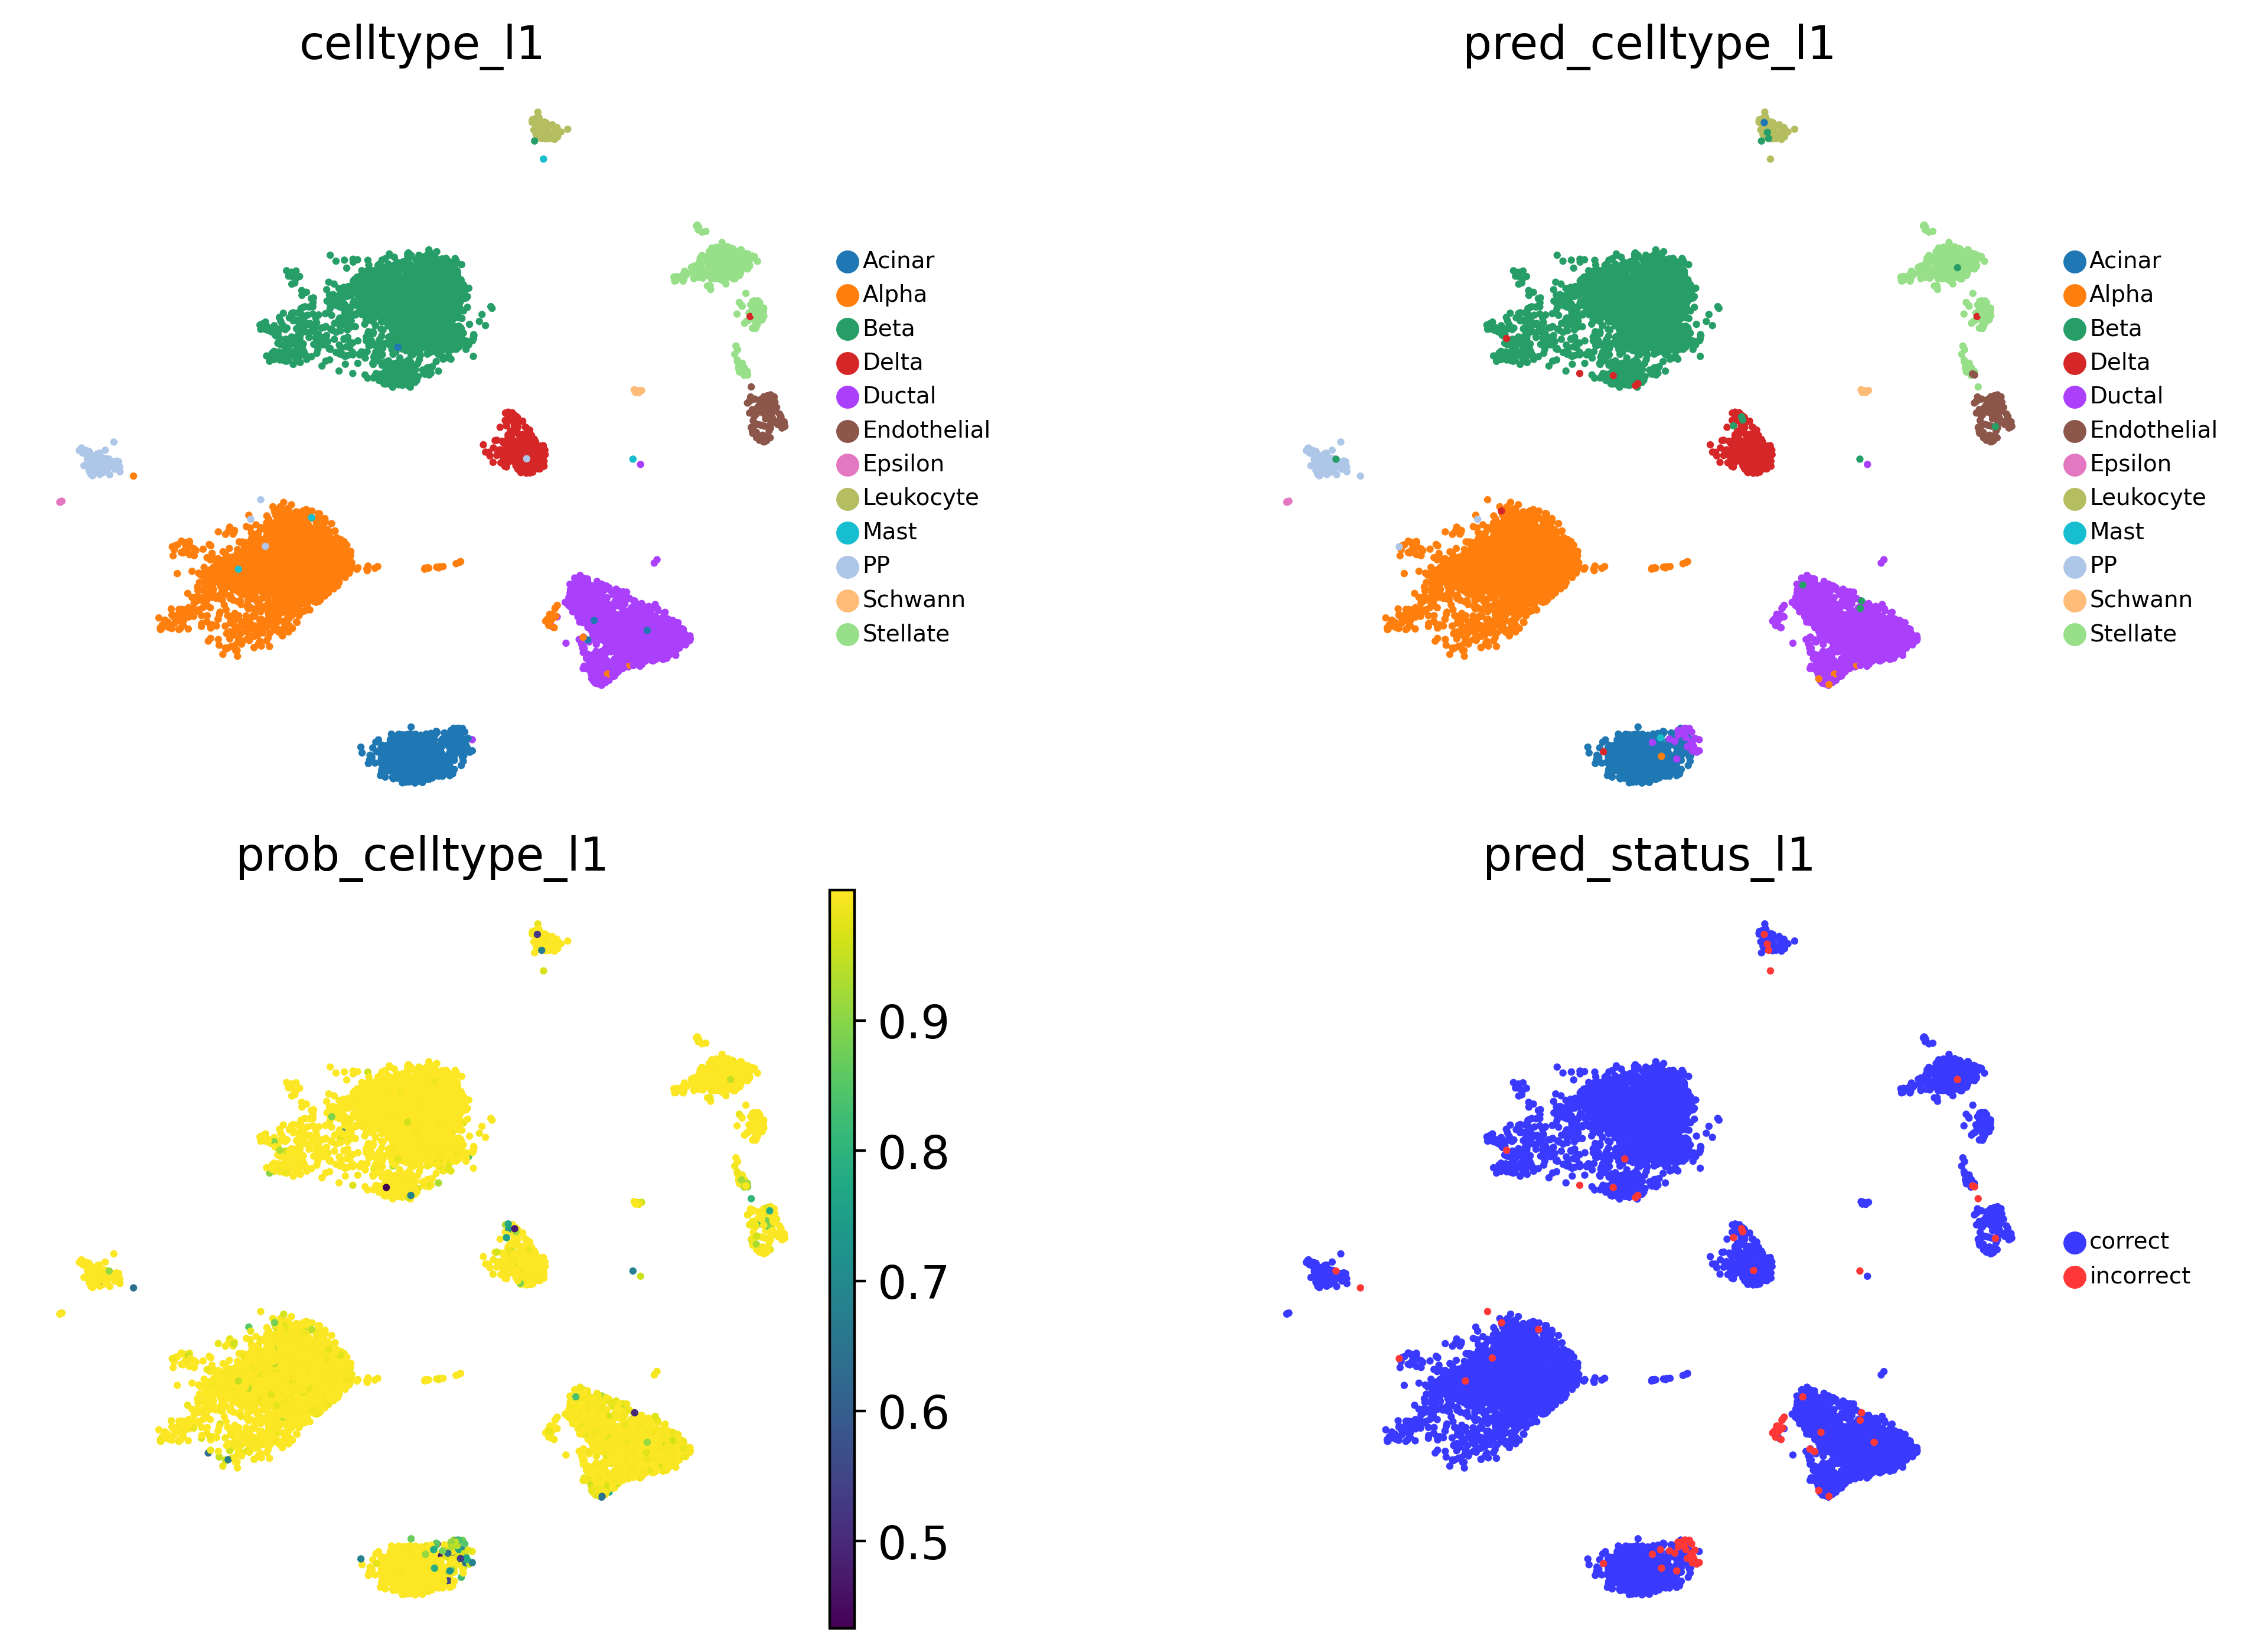

In [22]:
# Visualise predicted cell types levels, prediction probabilities and prediction status
sc.set_figure_params(dpi = 200, dpi_save=600)
adata_test_10 = adata_test_10[adata_test_10.obs['pred_status_l1'].sort_values().index,:]
sc.pl.embedding(adata_test_10, 
                color=[
                    'celltype_l1',
                    'pred_celltype_l1',
                    'prob_celltype_l1',
                    'pred_status_l1'
                ],
                sort_order = False,
                basis = 'X_umap',
                frameon = False,
                add_outline = False,
                legend_loc = 'right margin',
                legend_fontsize = 7,
                legend_fontoutline = 1,
                ncols=2,
                s = 20,
                wspace = 0.4, 
                hspace = 0.1,
                save = '_Pancreas_celltype_l1_scAdam_tuned.png')

In [14]:
import session_info
session_info.show()

In [23]:
# Train scadam model using adata_train dataset
scparadise.scadam.train(adata_train_1,
                        path = '',
                        model_name = 'model_Pancreas_scAdam_imbalanced',
                        celltype_l1 = 'celltype_l1',
                        eval_metric = ['accuracy'])


Successfully saved genes names for training model

Successfully saved dictionary of dataset annotations

Train dataset contains: 10066 cells, it is 90.0 % of input dataset
Test dataset contains: 1119 cells, it is 10.0 % of input dataset

Accelerator: cuda
Training unsupervised model
epoch 0  | loss: 254.24121| val_0_unsup_loss_numpy: 3.728149890899658|  0:00:00s
epoch 1  | loss: 36.4799 | val_0_unsup_loss_numpy: 2.518670082092285|  0:00:00s
epoch 2  | loss: 11.20092| val_0_unsup_loss_numpy: 1.4141499996185303|  0:00:01s
epoch 3  | loss: 3.89813 | val_0_unsup_loss_numpy: 1.2574599981307983|  0:00:01s
epoch 4  | loss: 1.58927 | val_0_unsup_loss_numpy: 1.201300024986267|  0:00:02s
epoch 5  | loss: 1.35966 | val_0_unsup_loss_numpy: 1.1813499927520752|  0:00:02s
epoch 6  | loss: 1.10138 | val_0_unsup_loss_numpy: 1.057420015335083|  0:00:02s
epoch 7  | loss: 1.08894 | val_0_unsup_loss_numpy: 1.0252100229263306|  0:00:03s
epoch 8  | loss: 1.08221 | val_0_unsup_loss_numpy: 0.977869987487793|  

In [27]:
for adata_test, folder in zip(lst_test_adatas, lst_test_folders):
    os.makedirs(os.path.join('Pancreas/scadam_imbalanced/reports', folder))
    # Predict annotation levels using pretrained scadam model
    adata_test = scparadise.scadam.predict(adata_test, 
                                           path_model = 'model_Pancreas_scAdam_imbalanced')
    # Create and save classification report of annotation levels
    scparadise.scnoah.report_classif_full(adata_test, 
                                          celltype = 'celltype', 
                                          pred_celltype = 'pred_celltype_l1', 
                                          report_name = 'report_test_model_scAdam_imbalanced_celltype_l1.csv',
                                          save_path = os.path.join('Pancreas/scadam_imbalanced/reports', folder).replace("\\","/"),
                                          save_report = True)

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training model

Successfully loaded dictionary of dataset annotations

Successfully loaded model

Successfully added predicted celltype_l1 and cell type probabilities
Successfully saved report

Successfully loaded list of genes used for training 